# Landsat calibration using MODIS SST
Create matchups between Landsat and MODIS SST data near Cosgrove, West Antarctica
to produce a calibration for Landsat SSTs

In [1]:
# Import libraries and modules
%config InlineBackend.figure_format = 'svg'
%matplotlib widget
import pandas as pd
import xarray as xr
import geopandas as gpd
from datetime import date, timedelta, datetime
import numpy as np
import matplotlib.pylab as plt
from matplotlib import colors
from matplotlib.pylab import rcParams
from matplotlib.patches import Polygon as Pgon
import cartopy.crs as ccrs
import cartopy

import os
from cycler import cycler
import pyproj
from pyproj import Proj, transform
from sklearn.neighbors import BallTree
import pytz
import pygmt
import gc
import copy
import random
import statsmodels.formula.api as sm
import scipy.stats as stats
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
# from shapely.geometry.polygon import Polygon
from shapely.geometry import Point, Polygon
from pathlib import Path
import math
from scipy.odr import Model, RealData, ODR
from tqdm.notebook import trange, tqdm

import earthaccess

import warnings
warnings.filterwarnings('ignore')

In [2]:
#For color cycling in plots that is color blind friendly...make new ones at "I want hue" tools.medialab.sciences-po.fr/iwanthue
color_cycler = cycler(color=["#6777cf","#adba49","#c65ca0","#5fa042","#683287","#72ce7b","#c44a48","#45c7a9","#933c1d","#d0803f","#ac9239","#317c39"])
colorline_cycler = (cycler(color=["#75a141","#6c61b9","#bc4d45","#c1913d","#b85298","#4aa8e8"]) +
                 cycler(linestyle=['-','--',':','-.','-','--']))
rcParams['axes.prop_cycle'] = cycler('color', color_cycler)

## Build Landsat - MODIS SST matchups

In [3]:
# Set paths and important variables and Calibration region bounding box

basepath = Path('/home/jovyan/Landsat_SST_algorithm')
spacing = [990,-990] # 990m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
param = 'sea_surface_temperature'
size_threshold = 30

location = 0             # 0 and 1 are the Cosgrove and Dotson Polynya calibration areas, respectively
surf_temp = 'SST'        # 'SST' and 'LST' are for the Landsat SST and LST algorithms respectively

# Set location bounds
if location==1:
    pathdir = 'DotsonPolynya'
    latboundsC = [ -73.9 , -73.5 ] # Dotson polynya
    lonboundsC = [ -113 , -111.5 ]
    dfloc = 'Dotson'
elif location==0:
    pathdir = 'Cosgrove'
    latboundsC = [ -73.5 , -73.42 ] # near Cosgrove
    lonboundsC = [ -103.0 , -102.0 ]
    dfloc = 'Cosgrove'
elif location==2:
    pathdir = 'Burke'
    latboundsC = [ -73.81 , -73.42 ] # south of Burke
    lonboundsC = [ -104.2 , -103.8 ]
    dfloc = 'Burke'
if location==3:
    pathdir = 'DotsonIntercomp'
    latboundsC = [ -74.2 , -74.11 ] # Dotson plume for intercomparison
    lonboundsC = [ -113.5 , -113.17 ]
    dfloc = 'DotsonIntercomp'

# latboundsC = [ -69.9, -69.6 ] # Offshore NE Amundsen, didn't use cuz couldn't get a viable dataset
# lonboundsC = [ -99.2 , -98.4 ]

# Coefficients for calibration
# SST
sstcalib_m = 0.94 
sstcalib_b = -0.08 

# LST
lstcalib_m = 0.56
lstcalib_b = 0.37

modmin = -1.9
LSTmin = np.around(modmin/lstcalib_m - lstcalib_b,2) 
SSTmin = np.around(modmin/sstcalib_m - sstcalib_b,2) # should be about -2.0


# For calibrated SST runs
if surf_temp=='SST':
    if location==3:
        sstpath = basepath / f'Data/SST/Validation/{pathdir}/'
    else:
        sstpath = basepath / f'Data/SST/MODcalib/{pathdir}/'
    tif = 'tif'
    thresh = SSTmin
    calib_m = sstcalib_m
    calib_b = sstcalib_b
    
# If running for LST comparisons
elif surf_temp=='LST':
    if location==3:
        sstpath = basepath / f'Data/SST/LST/Calibration/DotsonPolynya/'
    else:
        sstpath = basepath / f'Data/SST/LST/Calibration/{pathdir}/'
    tif = 'TIF'
    thresh = LSTmin
    calib_m = lstcalib_m
    calib_b = lstcalib_b

In [4]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [5]:
def lsat_reproj(old_cs,new_cs,lbox):
    '''
    bbox comes out with the points out of order for making a polygon though pairs are correct. Order is 0,3,1,2 when done in normal projection. 
    Haven't tested for flipped grid.
    '''
    
    test_threshold = 0.5
    
    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)
    
    ULX,LRY,LRX,ULY = lbox

    [lULX,lLRX], [lULY,lLRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
    [cULX,cLRX], [cULY,cLRY] =  transform(outProj,inProj,[lULX,lLRX], [lULY,lLRY], always_xy=True)
    [lLLX,lURX], [lLLY,lURY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)
    [cLLX,cURX], [cLLY,cURY] =  transform(outProj,inProj,[lLLX,lURX], [lLLY,lURY], always_xy=True)

    if LRY>ULY:
        bbox = [(lULX,lLLY),(lLLX,lULY),(lLRX,lURY),(lURX,lLRY)]
        print('lsat_reproj flipped orientation')
    else:
        bbox = [(lULX,lULY),(lLLX,lLLY),(lLRX,lLRY),(lURX,lURY)]
        print('lsat_reproj normal orientation')

    checkbox = np.array([cULX,cULY,cLRX,cLRY])
    if np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY])) > test_threshold:
        print(f"Round-trip transformation error 1 of {np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY]))}")
    checkbox = np.array([cLLX,cLLY,cURX,cURY])
    if np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY])) > test_threshold:
        print(f"Round-trip transformation error 2 of {np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY]))}")
    print (f'bbox={bbox}')
    print (f'lbox={lbox}')
    print (f'checkbox={checkbox}')
    
    return bbox,checkbox

##########################

def crop_xarray_dataarray_with_polygon(dataarray, polygon):
    """
    Crop an xarray.DataArray using a polygon.
    
    Parameters:
    - dataarray: xarray.DataArray with x and y coordinates.
    - polygon: Shapely Polygon object defining the crop area.
    
    Returns:
    - Cropped xarray.DataArray.
    """
    # Generate a 2D array of shapely Point objects for each grid point
    lon, lat = np.meshgrid(dataarray.x.values, dataarray.y.values)
    points = np.vectorize(Point)(lon, lat)
    
    # Create a mask where points within the polygon are True
    mask_func = np.vectorize(polygon.contains)
    mask = mask_func(points)
    
    # Convert the mask to an xarray.DataArray
    mask_da = xr.DataArray(mask, dims=["y", "x"], coords={"y": dataarray.y, "x": dataarray.x})
    
    # Apply the mask to the dataarray, cropping to the polygon
    # Use where method with drop=True to drop values outside the polygon
    cropped_dataarray = dataarray.where(mask_da, drop=True)
    
    return cropped_dataarray

##########################

def subset_img(da,polarx,polary):
    '''
    ***Only works for square grid cropping along the orientation of the grid (not when cropping along lat/lon in a 3031 grid
    
    Subset image in xarray to desired coordinates. Because Landsat polar stereo projection can be oriented
    in many different directions, when coordinates to subset an image are reprojected from lat/lon they may get 
    flipped for which is larger in the pair. This function checks to make sure we are getting a proper subset and 
    avoids 0 pixels on the x or y axis. 
    
    Note: Input shape dimensions and dataarray v. dataset changes things so input needs to be a dataarray w 
          2 dimensions (x,y)
    
    Input:
    da = xarray DataArray to be subset
    polarx = x coordinates to subset by in polar stereographic projection
    polary = y coordinates to subset by in polar stereographic projection
    
    Output:
    ls_sub = subset xarray DataArray
    
    '''
    # ***Landsat shape dimensions are one fewer than they are for LandsatCalibration [0,1] not [1,2], no .to_array() or Band
    ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))

    # Check for right dimensions because y order changes sometimes
    if (ls_sub.x.shape[0]==0) & (ls_sub.y.shape[0]==0):
        print ('L8 x and y shapes are 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
    elif ls_sub.y.shape[0]==0:
        print ('L8 y shape is 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1]))
    elif ls_sub.x.shape[0]==0:
        print ('L8 x shape is 0')
        ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[1],polarx[0]))
    print(da.shape)
    print(ls_sub.shape)
    
    return ls_sub
    
##########################

def crosses_idl(coords):
    '''
    Determine if the set of coordinates crosses the International Dateline in a way that will mess up the creation of a polygon
    
    Variables:
    coords = list of lon, lat tuples
    
    Output:
    True or False
    '''
    
    for (lon1, lat1), (lon2, lat2) in zip(coords, coords[1:]):
        if abs(lon1 - lon2) >= 180:
            return True
    return False

##########################

# Preprocess to add time dimension and the file name to open_mfdataset for landsat using the filename
def add_time_dim(ds):
    lstr = ds.encoding["source"].split("LC0",1)[1]
    times = pd.to_datetime(lstr[14:22]+lstr[38:44], format='%Y%m%d%H%M%S')
    idee = ds.encoding["source"].split("/")[8][:-4] # The first number depends on how many subdirectories the file is in
    return ds.assign_coords(time=times,ID=idee)

In [6]:
def find_MODIS(lonboundsC,latboundsC,ls_scene):
    '''
    Finds the MODIS scene most closely coincident to a Landsat scene
    Uses full Landsat scene extent, not cropped
    
    Variables: 
    ls_scene = xarray for one Landsat scene
    
    Outputs:
    mod_scene = xarray of MODIS SST image coincident in time with the Landsat scene
    granules[ind]['umm']['GranuleUR'] = modis file name
    min_time = the time difference between the Landsat image acquisition and chosen MODIS image
    
    **not done, Differences from NLSST: 0.0 used as percent_dif requiring 100% overlap between MODIS and Landsat here since the subset area is so small
    '''
    
    mbox = (lonboundsC[0],latboundsC[0],lonboundsC[1],latboundsC[1]) #east, south,west,north

    # Construct a polygon to select a best fit MODIS image based on overlap
    # Using the entire Landsat image
    ls_scene_reproj = ls_scene.rio.reproject("EPSG:4326")
    xmin,xmax,ymin,ymax = ls_scene_reproj.x.values[0],ls_scene_reproj.x.values[-1],ls_scene_reproj.y.values[0],ls_scene_reproj.y.values[-1]
    lsatpoly = Polygon([(xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin),(xmin,ymin)])
    # # (Not using) Using only the sampling box
    # # (Note) This produces artifacts in MODIS_lookup because the Landsat grid will be an extrapolation outside the MODIS grid and streaking occurs
    # lsatpoly = Polygon([(lonboundsC[0],latboundsC[1]),(lonboundsC[0],latboundsC[0]),(lonboundsC[1],latboundsC[0]),(lonboundsC[1],latboundsC[1]),(lonboundsC[0],latboundsC[1])])
    
    # Get date/time for Landsat image and search for corresponding MODIS imagery  
    ls_time = pd.to_datetime(ls_scene.time.values)
    calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
    end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')
    
    # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
    granules = earthaccess.search_data(
        short_name='MODIS_T-JPL-L2P-v2019.0',
        bounding_box=mbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules2 = earthaccess.search_data(
        short_name='MODIS_A-JPL-L2P-v2019.0', #MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_NIGHTTIME_V2019.0
        bounding_box=mbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules = granules + granules2
    print (f'{len(granules)} TOTAL MODIS granules')

    # Accept only MODIS granules that overlap at least a perscribed amount with Landsat, in this case 100% => percent_dif=0.0
    best_grans = []
    for granule in granules:
        try:
            granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
        except Exception as error:
            print(error)
            continue
            # Would love to raise an exception for a valueerror except for GEOSError
        for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
            try:
                # Extract points, make into a polygon
                map_points = [(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']]
                pgon = Polygon(map_points)
                percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
                # If the polygon covers the landsat area, check to make sure it doesn't cross the international date line with a messed up polygon (these are searched wrong in earthaccess so probably need adjustment there)
                if percent_dif == 0.0:
                    if crosses_idl(map_points):
                        print (f'A granule has messed up polygon that likely crosses the International DateLine')
                    else:
                        best_grans.append(granule)
                        continue
            except Exception as error:
                print(error)
                # Would love to raise an exception for a valueerror except for GEOSError
    print(f'{len(best_grans)} remaining MODIS granules')

    # Find MODIS image closest in time to each Landsat image
    # Make Landsat datetime timezone aware (UTC)
    Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
    ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(ls_time))))
    time_dif = abs(Mdates[ind] - pytz.utc.localize(pd.to_datetime(ls_time)))
    print(f'Time difference between MODIS and Landsat: {time_dif}')

    mod_scene = xr.open_dataset(earthaccess.open(best_grans[ind:ind+1])[0])
    mod_scene = mod_scene.rio.write_crs("epsg:4326", inplace=True) 
    
    return mod_scene, granules[ind]['umm']['GranuleUR'],time_dif

##########################  

def get_wv(ls_scene,mod07,spacing,param):
    '''
    ***This is copied in LandsatCalibration, modifications have been made but some may tranfer
    
    Create MODIS files aligned and subsampled to Landsat
    
    Variables:
    ls_scene = xarray dataset of a Landsat scene
    mod07 = xarray datarray with MODIS data
    spacing = list of desired spatial resolution of output data from the alignment of MODIS to Landsat in y and x (e.g.,[300,-300])
    param = string for desired dataset from MODIS file
    
    Output:
    WV_xr = xarray dataarray of Landsat aligned and upsampled modis data from desired dataset
    
    Differences from NLSST: scene is not a parameter (used for test_gridcoords), SST gets extracted differently into data/lat/lon
    
    '''
    # Read in desired variables and paths
    
    uniqWV = []

    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]
    LRX = ls_scene.x[-1]
    LRY = ls_scene.y[-1] 
    box = [ULX,LRX,ULY,LRY]
    
    #Extract desired datasets from MODIS file
    if param == 'sea_surface_temperature': 
        data = mod07[0,:,:]
        lat, lon = mod07.lat, mod07.lon
    else: 
        data = mod07[param]
        lat, lon = mod07.Latitude, mod07.Longitude    

    # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
    indiciesMOD,lines,samples = MODISlookup(mod07,ls_scene,box,spacing)

    # Align MODIS SST to Landsat on slightly upsampled grid # have the option to output `uniqImgWV` if want to know range of data
    dataOutWV_xr = alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing)

    # Resample MODIS to Landsat resolution and interpolate with B-spline
    # Output of shape fits and need to adjust x and y coords cuz are wrong
    ups_factor = 30/spacing[0]
    WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k') # ,interpolation='b' if prefer to interpolate with bspline but don't think it is useful here

    # Put into Xarray
    latnew = ls_scene.y[:WV_upsample.shape[0]].values
    lonnew = ls_scene.x[:WV_upsample.shape[1]].values
    if dataOutWV_xr.latitude[0]!=latnew[0]:
        print('Aligned y dim needs to start with the same coordinate as ls_scene')
    if dataOutWV_xr.longitude[0]!=lonnew[0]:
        print('Aligned x dim needs to start with the same coordinate as ls_scene')
    
    WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})
    WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
    WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})
    WV_xr = WV_xr.set_index(x='x')
    WV_xr = WV_xr.set_index(y='y')

#     #Append WV values
#     uniqWV.append(uniqImgWV)
    
#     try:
#         # Min and max MODIS values for a scene
#         maxi =[]
#         mini =[]
#         for m in uniqWV:
#             maxi.append(max(m))
#             mini.append(min(m))

#         print (f'Max {param}: {np.max(maxi)}, min: {np.min(mini)}')
#     except:
#         print (f'Max {param}: {np.nan}, min: {np.nan}')
    
    return WV_xr
           
##########################           

def MODISlookup (mod07,ls_scene,box,spacing):
    '''
    Look up atmospheric consituents from MODIS product for each Landsat pixel
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
    # and Shane Grigsby

    Variables:    
    mod07 = xarray with MODIS data with crs 4326 assigned
    ls_scene =  Landsat xarray DataArray
    box = list with [left easting,right easting,top northing,bottom northing]
    spacing = desired pixel size for extraction, list of [east/west, north/south] 
          (recommend choosing a number that allows for fast calculations and even division by 30)

    Output:
    indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    x1,y1 = x and y coordinates for grid
    
    Differences from NLSST: lat/lon variables named differently in SST vs WV files, no interpolation,
    test_gridcoords does not use `scene`, don't need to output lat/lon because do not interpolate and make 
    new ones
    
    '''
    test_threshold = 5 
    
    lat, lon = mod07.lat, mod07.lon # Different for SST vs WV
    
    # Test lat is in correct range
    if ~((lat <= 90) & (lat >= -90)).all():
        print('MODIS latitude not between -90 and 90')
    # Test lon is in correct range
    if ~((lon <= 180) & (lon >= -180)).all():
        print('MODIS longitude not between -180 and 180')

    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs # 'epsg:3031'
    new_cs = mod07.rio.crs # 'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)

    # Parse coordinates and spacing to different variables
    west,east,north,south = box
    ewspace,nsspace = spacing

    # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
    samples = len(np.r_[west:east+1:ewspace])
    lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
    if lines==0:
        lines = len(np.r_[south:north-1:nsspace])
        
    # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
    ewdnsamp = int(spacing[0]/30)
    nsdnsamp = int(spacing[1]/30)

    # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
    xresamp = ls_scene.x.isel(x=slice(None, None, ewdnsamp)).values
    if xresamp[0]!=ls_scene.x.values[0]:
        xresamp = ls_scene.x.isel(x=slice(None, None, -ewdnsamp)).values
        
    yresamp = ls_scene.y.isel(y=slice(None, None, nsdnsamp)).values
    if yresamp[0]!=ls_scene.y.values[0]:
        yresamp = ls_scene.y.isel(y=slice(None, None, -nsdnsamp)).values

    x1, y1 = np.meshgrid(xresamp,yresamp)
    LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
    if (LScoords[0,0]!=ls_scene.x.values[0]) |  (LScoords[0,1]!=ls_scene.y.values[0]):
        raise Exception('Landsat coordinates do not match expected during MODIS lookup')

    # Ravel so ND can lookup easily
    # Convert from LS map coords to lat lon --> x = lon, y = lat (usually?)
    # Test that reprojection is working correctly on first and last grid point using round-trip transformation
    xs1, ys1 =  transform(inProj,outProj,LScoords[0,0], LScoords[0,1], radians=True, always_xy=True)
    xsl1, ysl1 =  transform(outProj,inProj,xs1, ys1, radians=True, always_xy=True)
    if np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:]) > test_threshold:
        print(f"Round-trip transformation error for point {LScoords[0,:]}, {np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:])}")
    else:
        # If passes, run on entire grid
        xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)

    # Produce landsat reprojected to lat/lon and ensure lat is in 0 column
    grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T
    # Test that lines and samples match grid_coords
    if len(grid_coords) != lines*samples:
        raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}. Check that spacing is negative for y')
    MODIS_coords = np.vstack([lat.values.ravel(),lon.values.ravel()]).T
    MODIS_coords *= np.pi / 180. # to radians
    
    # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
    MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
    distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
    return indiciesMOD,lines,samples

##########################

def test_gridcoords(xs,ys):
    '''
    Test to ensure grid lat and lon are not swapped during reprojection and output grid coordinates
    that have been raveled and stacked for input into BallTree. There is some uncertainty only when the image is
    taken between -60 and -90 longitude because lat and lon can have the same values.
    
    Variables:
    xs = 1D radians representing longitude 
    ys = 1D radians representing latitude
    
    Output:
    grid_coords = two columns of x/y radian pairs representing lon/lat
    
    Differences from NLSST: elif is different than NLSST pipeline
    '''
    
    # Convert radians to lat/lon
    x_check = xs * 180. / np.pi
    y_check = ys * 180. / np.pi
    
    # We know lat is ys and lon is xs if this is true so goes in 0 column position to match MODIS
    if ((-90 <= y_check) & (y_check <= -60)).all() & ~((-90 <= x_check) & (x_check <= -60)).all():
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
        print('Latitude in proper position')

    # A small subset of data have lat and lon that falls between -60 and -90 so test if the landsat metadata confirms that
    elif ((-90 <= y_check) & (y_check <= -60)).all():
        # xs is latitude if not and goes in 0 column position
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T 
        print('Latitude in uncertain position, may be incorrect')

    # Otherwise xs is latitude and goes in 0 column position
    else:
        grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T
        print('Latitude in wrong position')
    
    return grid_coords

##########################

def alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing):
    '''
    Align MODIS image to Landsat and resample at indicated spacing
    
    Variables:
    data =
    lat = 
    lon = 
    param =
    indiciesMOD =
    lines = 
    samples =
    mod07 = 
    ls_scene =
    spacing =
    
    Output:
    dataOut_xr = 
    
    Not currently set, but can also output: 
    uniqImg = uniq MODIS atm values within area of Landsat image
    '''
    test_threshold = 5
    
    if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
            raise Exception("Error in creating indicies, lat/lon and data shapes do not match")
            
    # Extract MODIS data into Landsat grid and gather unique data values
    dataOut,uniqImg = uniqueMODIS(data,param,indiciesMOD,lines,samples)
    
    # Check grid directionality and create matching x/y for new grid
    # Define the source and target coordinate reference systems (CRS)
    src_crs = mod07.rio.crs #'epsg:4326'  MODIS
    target_crs = ls_scene.rio.crs #crs[6:] # 'epsg:3031' Landsat

    # Create a PyProj transformer
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
    transformer_test = pyproj.Transformer.from_crs(target_crs, src_crs, always_xy=True)

    # Test that reprojection is working correctly on first and last grid point
    xm1,xm2 = lon[0,0],lon[-1,-1]
    ym1,ym2 = lat[0,0],lat[-1,-1]
    xx,yy = [xm1,xm2], [ym1,ym2]
    xs1, ys1 =  transformer.transform(xx,yy)
    xsl1, ysl1 = transformer_test.transform(xs1, ys1)
    for i,n in enumerate(xsl1):
        if np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - [xx[i],yy[i]]) > test_threshold:
            print(f"Round-trip transformation error for {sceneid}, {np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - xx[i],yy[i])}")

    # Spacing to create x and y parameters at the correct spacing
    red_y = int(abs(spacing[0]/30))
    red_x = int(abs(spacing[1]/30))

    # Set up coarser sampling grid to match spacing and check to make sure is in the same orientation as the original Landsat grid
    xgrid = ls_scene.x.values[0::red_x]
    if len(xgrid)==1:
        xgrid = ls_scene.x.values[0::-red_x]
    if xgrid[0]!=ls_scene.x.values[0]:
        xgrid = np.flip(xgrid)
        print ('Align x flip')
    ygrid = ls_scene.y.values[0::red_y]
    if len(ygrid)==1:
        ygrid = ls_scene.y.values[0::-red_y]
    if ygrid[0]!=ls_scene.y.values[0]:
        ygrid = np.flip(ygrid)
        print ('Align y flip')
    if (xgrid[0]!=ls_scene.x.values[0]) |  (ygrid[0]!=ls_scene.y.values[0]):
        raise Exception(f'Landsat coordinates do not match expected during MODIS align')
    
    # Create xarray from numpy array
    dataOut_xr = xr.DataArray(dataOut,name='SST',dims=["y","x"], coords={"latitude": (["y"],ygrid), "longitude": (["x"],xgrid)})
    
    return dataOut_xr #,uniqImg


##########################

def uniqueMODIS(data,param,indiciesMOD,lines,samples):
    '''
    Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
    Variables: 
    mod07 = xarray with MODIS data with crs 4326 assigned  
    param = 
    indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    
    Output:
    dataOut = MODIS atm image subset and aligned to Landsat pixel grid
    uniq = uniq MODIS atm values within area of Landsat image
    
    Differences from NLSST: SST paramater scaling, etc is different
    '''
    # To convert from K to C
    KtoC = -273.15
    
    # Scaling coefficients for MODIS data
    wv_scale = 0.0010000000474974513
    ozone_scale = 0.10000000149011612

    # Reproject data from MODIS into corresponding postions for Landsat pixels for the desired dataset
    # Remove unrealistic data/outliers
    if param == 'sea_surface_temperature':  
        #Extract desired datasets from MODIS file from lookup key
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD],(lines,samples)) + KtoC #* # to scale?
        dataOut[dataOut < -3.5] = np.nan
        
    if param == 'Water_Vapor':
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD] * wv_scale,(lines,samples))
        dataOut[dataOut < 0] = np.nan
        MODimg = np.array(data.values*wv_scale)
        MODimg[MODimg < 0] = np.nan
        
    if param == 'Total_Ozone':
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD] * ozone_scale,(lines,samples))
        dataOut[dataOut < 225] = np.nan
        dataOut[dataOut > 430] = np.nan
        MODimg = np.array(data.values*ozone_scale)
        MODimg[MODimg < 0] = np.nan

    # Get unique values for datasets within Landsat extent
    #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
    uniq = set(dataOut[np.isfinite(dataOut)])
    
    return dataOut,uniq # Can also output MODimg and inverse and counts if desired

In [7]:
# Convert bounding box to south polar stereo for checking if landsat has any data in bounding box
# Speeds up process a lot
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

bbox,checkbox = lsat_reproj(source_crs,target_crs,(lonboundsC[0],latboundsC[0],lonboundsC[1],latboundsC[1]))

# Create polygon for later cropping
polygon = Polygon([(bbox[0][0],bbox[0][1]),(bbox[3][0],bbox[3][1]),(bbox[2][0],bbox[2][1]),(bbox[1][0],bbox[1][1])])

# Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
minx, miny, maxx, maxy = polygon.bounds
polarx = [minx, maxx]
polary = [miny, maxy]

lsat_reproj normal orientation
bbox=[(-1767143.3032312603, -407977.17787665356), (-1758502.0895972336, -405982.19651583635), (-1765319.6275113877, -375230.27027242474), (-1773994.3422722665, -377074.1378154654)]
lbox=(-103.0, -73.5, -102.0, -73.42)
checkbox=[-103.    -73.5  -102.    -73.42]


In [8]:
# Get Landsat file paths in directory
lsatfiles = os.listdir(sstpath)
lsatfiles = [x for x in lsatfiles if x[-3:] == tif]
lsatfiles.sort()
print (len(lsatfiles))
os.chdir(sstpath)

    # pairs = []

    # for SSTfile in lsatfiles:
    #     for LSTfile in lstfiles:
    #         if SSTfile[:40]==LSTfile[:40]:
    #             pairs.append((sstpath / SSTfile,lstpath / LSTfile))
    #             continue
    # print (len(pairs))

70


In [10]:
lsatfiles = [
 'LC08_L1GT_012112_20211031_20211109_02_T2_155951_Cel.tif',
 'LC08_L1GT_012112_20211202_20211209_02_T2_155947_Cel.tif',
 'LC08_L1GT_012112_20220103_20220113_02_T2_155940_Cel.tif',
 'LC08_L1GT_012112_20220204_20220212_02_T2_155933_Cel.tif',
 'LC08_L1GT_012112_20220324_20220329_02_T2_155914_Cel.tif',
 'LC08_L1GT_012112_20221221_20221228_02_T2_155948_Cel.tif',
 'LC08_L1GT_012112_20230106_20230110_02_T2_155949_Cel.tif',
 'LC08_L1GT_012112_20230122_20230207_02_T2_155945_Cel.tif',
 'LC08_L1GT_012112_20230207_20230217_02_T2_155946_Cel.tif',
 'LC08_L1GT_012112_20230311_20230320_02_T2_155924_Cel.tif',
 'LC08_L1GT_012112_20230327_20230405_02_T2_155914_Cel.tif',
 'LC08_L1GT_161132_20211206_20211214_02_T2_072838_Cel.tif',
 'LC08_L1GT_161132_20220107_20220114_02_T2_072831_Cel.tif',
 'LC08_L1GT_161132_20221225_20230103_02_T2_072840_Cel.tif',
 'LC08_L1GT_161132_20230110_20230124_02_T2_072839_Cel.tif',
 'LC08_L1GT_162132_20211213_20211223_02_T2_073448_Cel.tif',
 'LC08_L1GT_162132_20221130_20221206_02_T2_073501_Cel.tif',
 'LC08_L1GT_162132_20230101_20230110_02_T2_073452_Cel.tif',
 'LC08_L1GT_163131_20211204_20211208_02_T2_074036_Cel.tif',
 'LC08_L1GT_163131_20211220_20211229_02_T2_074034_Cel.tif',
 'LC08_L1GT_163131_20220105_20220114_02_T2_074029_Cel.tif',
 'LC08_L1GT_163131_20221207_20221213_02_T2_074047_Cel.tif',
 'LC08_L1GT_163131_20230108_20230124_02_T2_074038_Cel.tif',
 'LC08_L1GT_164131_20211211_20211214_02_T2_074646_Cel.tif',
 'LC08_L1GT_164131_20211227_20220105_02_T2_074642_Cel.tif',
 'LC08_L1GT_164131_20220112_20220122_02_T2_074639_Cel.tif',
 'LC08_L1GT_165131_20211218_20211223_02_T2_075256_Cel.tif',
 'LC08_L1GT_165131_20220103_20220114_02_T2_075251_Cel.tif',
 'LC08_L1GT_165131_20221221_20221228_02_T2_075300_Cel.tif',
 'LC08_L1GT_165132_20211218_20211223_02_T2_075320_Cel.tif',
 'LC08_L1GT_165132_20221221_20221228_02_T2_075323_Cel.tif',
 'LC08_L1GT_165132_20230106_20230110_02_T2_075324_Cel.tif']

In [9]:
lsatfiles = [
    # # LST DotsonIntercomp good images
 # # 'LC08_L1GT_007112_20211215_20211223_02_T2_SW_LST.TIF',
 # # 'LC08_L1GT_007112_20220201_20220211_02_T2_SW_LST.TIF',
 # # 'LC08_L1GT_007112_20221202_20221212_02_T2_SW_LST.TIF',
 # # 'LC08_L1GT_007112_20230204_20230209_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_007113_20220201_20220211_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_007113_20220321_20220329_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_007113_20220929_20221004_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_007113_20221116_20221128_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_007113_20221202_20221212_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_007113_20230204_20230209_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_007113_20230308_20230320_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_007113_20230324_20230404_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_008113_20220107_20220114_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_008113_20220312_20220321_02_T2_SW_LST.TIF',
 # # 'LC08_L1GT_008113_20221022_20221101_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_008113_20221123_20221205_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_008113_20221225_20230113_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_009112_20230117_20230131_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_009112_20230218_20230223_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_009113_20220215_20220223_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_009113_20221114_20221122_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_009113_20230117_20230131_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_009113_20230202_20230209_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_009113_20230218_20230223_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_009113_20230322_20230404_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20211204_20211214_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20211220_20211229_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20220105_20220114_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20220121_20220128_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20220206_20220212_02_T2_SW_LST.TIF',
 # # 'LC08_L1GT_010112_20221020_20221101_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20221105_20221115_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20221121_20221129_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20221223_20230103_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20230108_20230124_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010112_20230313_20230321_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010113_20220105_20220114_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010113_20220121_20220128_02_T2_SW_LST.TIF',
 # # 'LC08_L1GT_010113_20221020_20221101_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010113_20221105_20221115_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010113_20230108_20230124_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_010113_20230313_20230321_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_011112_20220112_20220123_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_011112_20220213_20220222_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_011112_20221112_20230113_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_011112_20230131_20230208_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_012112_20220204_20220212_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_012112_20220324_20220329_02_T2_SW_LST.TIF',
 # # 'LC08_L1GT_012112_20221018_20221031_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_012112_20221221_20221228_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_012112_20230106_20230110_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_012112_20230122_20230207_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_012112_20230311_20230320_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_162132_20211213_20211223_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_163131_20211220_20211229_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_163131_20220105_20220114_02_T2_SW_LST.TIF',
 # 'LC08_L1GT_164131_20211227_20220105_02_T2_SW_LST.TIF']
    
    # # SST Burke good images
 # 'LC08_L1GT_002112_20210923_20210930_02_T2_145755_Cel.tif',
 # 'LC08_L1GT_002112_20211009_20211019_02_T2_145801_Cel.tif',
 # 'LC08_L1GT_002112_20211110_20211117_02_T2_145800_Cel.tif',
 # 'LC08_L1GT_002112_20211126_20211201_02_T2_145758_Cel.tif',
 # 'LC08_L1GT_002112_20211228_20220105_02_T2_145753_Cel.tif',
 # 'LC08_L1GT_002112_20220214_20220222_02_T2_145741_Cel.tif',
 # 'LC08_L1GT_002112_20221129_20221206_02_T2_145811_Cel.tif',
 # 'LC08_L1GT_002112_20230116_20230131_02_T2_145754_Cel.tif',
 # 'LC08_L1GT_002112_20230201_20230209_02_T2_145800_Cel.tif',
 # 'LC08_L1GT_002112_20230217_20230223_02_T2_145750_Cel.tif',
 # 'LC08_L1GT_002112_20230321_20230325_02_T2_145729_Cel.tif',
 # 'LC08_L1GT_002112_20230406_20230412_02_T2_145717_Cel.tif',
 # 'LC08_L1GT_002113_20210923_20210930_02_T2_145819_Cel.tif',
 # 'LC08_L1GT_002113_20211009_20211019_02_T2_145825_Cel.tif',
 # 'LC08_L1GT_002113_20211110_20211117_02_T2_145824_Cel.tif',
 # 'LC08_L1GT_002113_20211126_20211201_02_T2_145822_Cel.tif',
 # 'LC08_L1GT_002113_20211228_20220105_02_T2_145817_Cel.tif',
 # 'LC08_L1GT_002113_20220113_20220123_02_T2_145814_Cel.tif',
 # 'LC08_L1GT_002113_20220214_20220222_02_T2_145805_Cel.tif',
 # 'LC08_L1GT_002113_20221113_20230113_02_T2_145835_Cel.tif',
 # 'LC08_L1GT_002113_20221129_20221206_02_T2_145835_Cel.tif',
 # 'LC08_L1GT_002113_20230116_20230131_02_T2_145818_Cel.tif',
 # 'LC08_L1GT_002113_20230201_20230209_02_T2_145824_Cel.tif',
 # 'LC08_L1GT_002113_20230217_20230223_02_T2_145814_Cel.tif',
 # 'LC08_L1GT_002113_20230321_20230325_02_T2_145753_Cel.tif',
 # 'LC08_L1GT_003112_20210914_20210924_02_T2_150405_Cel.tif',
 # 'LC08_L1GT_003112_20210930_20211013_02_T2_150409_Cel.tif',
 # 'LC08_L1GT_003112_20211117_20211125_02_T2_150407_Cel.tif',
 # 'LC08_L1GT_003112_20211203_20211209_02_T2_150409_Cel.tif',
 # 'LC08_L1GT_003112_20211219_20211223_02_T2_150407_Cel.tif',
 # 'LC08_L1GT_003112_20220104_20220113_02_T2_150402_Cel.tif',
 # 'LC08_L1GT_003112_20220120_20220127_02_T2_150359_Cel.tif',
 # 'LC08_L1GT_003112_20220325_20220329_02_T2_150336_Cel.tif',
 # 'LC08_L1GT_003112_20221104_20221114_02_T2_150426_Cel.tif',
 # 'LC08_L1GT_003112_20221206_20221212_02_T2_150421_Cel.tif',
 # 'LC08_L1GT_003112_20230107_20230107_02_T2_150412_Cel.tif',
 # 'LC08_L1GT_003112_20230107_20230111_02_T2_150412_Cel.tif',
 # 'LC08_L1GT_003112_20230123_20230207_02_T2_150409_Cel.tif',
 # 'LC08_L1GT_003112_20230312_20230321_02_T2_150346_Cel.tif',
 # 'LC08_L1GT_003113_20210914_20210924_02_T2_150429_Cel.tif',
 # 'LC08_L1GT_003113_20210930_20211013_02_T2_150433_Cel.tif',
 # 'LC08_L1GT_003113_20211117_20211125_02_T2_150431_Cel.tif',
 # 'LC08_L1GT_003113_20211219_20211223_02_T2_150431_Cel.tif',
 # 'LC08_L1GT_003113_20220104_20220113_02_T2_150426_Cel.tif',
 # 'LC08_L1GT_003113_20220120_20220127_02_T2_150423_Cel.tif',
 # 'LC08_L1GT_003113_20221206_20221212_02_T2_150445_Cel.tif',
 # 'LC08_L1GT_003113_20230107_20230107_02_T2_150436_Cel.tif',
 # 'LC08_L1GT_003113_20230107_20230111_02_T2_150436_Cel.tif',
 # 'LC08_L1GT_003113_20230123_20230207_02_T2_150433_Cel.tif',
 # 'LC08_L1GT_003113_20230312_20230321_02_T2_150410_Cel.tif',
 # 'LC08_L1GT_004112_20211226_20220105_02_T2_151015_Cel.tif',
 # 'LC08_L1GT_004112_20220111_20220122_02_T2_151012_Cel.tif',
 # 'LC08_L1GT_004112_20220127_20220204_02_T2_151007_Cel.tif',
 # 'LC08_L1GT_004112_20220316_20220321_02_T2_150953_Cel.tif',
 # 'LC08_L1GT_004112_20221111_20221121_02_T2_151034_Cel.tif',
 # 'LC08_L1GT_004112_20230114_20230130_02_T2_151018_Cel.tif',
 # 'LC08_L1GT_004112_20230130_20230208_02_T2_151021_Cel.tif',
 # 'LC08_L1GT_004112_20230404_20230412_02_T2_150941_Cel.tif',
 # 'LC08_L1GT_005112_20210928_20211013_02_T2_151630_Cel.tif',
 # 'LC08_L1GT_005112_20211030_20211109_02_T2_151635_Cel.tif',
 # 'LC08_L1GT_005112_20211201_20211209_02_T2_151631_Cel.tif',
 # 'LC08_L1GT_005112_20220102_20220113_02_T2_151624_Cel.tif',
 # 'LC08_L1GT_005112_20220203_20220212_02_T2_151617_Cel.tif',
 # 'LC08_L1GT_005112_20220219_20220302_02_T2_151611_Cel.tif',
 # 'LC08_L1GT_005112_20220307_20220315_02_T2_151609_Cel.tif',
 # 'LC08_L1GT_005112_20221204_20221212_02_T2_151643_Cel.tif',
 # 'LC08_L1GT_005112_20221220_20221227_02_T2_151634_Cel.tif',
 # 'LC08_L1GT_005112_20230121_20230207_02_T2_151629_Cel.tif',
 # 'LC08_L1GT_005112_20230206_20230217_02_T2_151631_Cel.tif',
 # 'LC08_L1GT_005112_20230222_20230301_02_T2_151616_Cel.tif',
 # 'LC08_L1GT_005112_20230310_20230320_02_T2_151608_Cel.tif',
 # 'LC08_L1GT_005112_20230326_20230404_02_T2_151559_Cel.tif',
 # 'LC08_L1GT_006112_20211021_20211103_02_T2_152246_Cel.tif',
 # 'LC08_L1GT_006112_20211208_20211215_02_T2_152242_Cel.tif',
 # 'LC08_L1GT_006112_20211224_20211230_02_T2_152238_Cel.tif',
 # 'LC08_L1GT_006112_20220226_20220309_02_T2_152221_Cel.tif',
 # 'LC08_L1GT_006112_20220314_20220321_02_T2_152216_Cel.tif',
 # 'LC08_L1GT_006112_20220330_20220405_02_T2_152204_Cel.tif',
 # # 'LC08_L1GT_006112_20221024_20221107_02_T2_152257_Cel.tif',
 # 'LC08_L1GT_006112_20221125_20221205_02_T2_152253_Cel.tif',
 # 'LC08_L1GT_006112_20230112_20230125_02_T2_152241_Cel.tif',
 # 'LC08_L1GT_006112_20230128_20230227_02_T2_152243_Cel.tif',
 # 'LC08_L1GT_006112_20230213_20230218_02_T2_152237_Cel.tif',
 # 'LC08_L1GT_006112_20230301_20230315_02_T2_152223_Cel.tif',
 # 'LC08_L1GT_006112_20230317_20230324_02_T2_152216_Cel.tif',
 # 'LC08_L1GT_006112_20230402_20230412_02_T2_152205_Cel.tif',
 # 'LC08_L1GT_155132_20211212_20211223_02_T2_065133_Cel.tif',
 # 'LC08_L1GT_155132_20221129_20221206_02_T2_065145_Cel.tif',
 # 'LC08_L1GT_155132_20221231_20230111_02_T2_065137_Cel.tif',
 # 'LC08_L1GT_156132_20211219_20211223_02_T2_065742_Cel.tif',
 # 'LC08_L1GT_156132_20220104_20220114_02_T2_065737_Cel.tif',
 # 'LC08_L1GT_156132_20221206_20230113_02_T2_065756_Cel.tif',
 # 'LC08_L1GT_156132_20221222_20230113_02_T2_065745_Cel.tif',
 # 'LC08_L1GT_156132_20230107_20230110_02_T2_065747_Cel.tif',
 # 'LC08_L1GT_157132_20211226_20211229_02_T2_070350_Cel.tif',
 # 'LC08_L1GT_157132_20220111_20220122_02_T2_070347_Cel.tif',
 # 'LC08_L1GT_157132_20221213_20221219_02_T2_070404_Cel.tif',
 # 'LC08_L1GT_157132_20221229_20230104_02_T2_070358_Cel.tif',
 # 'LC08_L1GT_158132_20220102_20220105_02_T2_070959_Cel.tif',
 # 'LC08_L1GT_158132_20221204_20230113_02_T2_071018_Cel.tif',
 # 'LC08_L1GT_158132_20221220_20221227_02_T2_071009_Cel.tif',
 # 'LC08_L1GT_159131_20211224_20211229_02_T2_071549_Cel.tif',
 # 'LC08_L1GT_159131_20221125_20221205_02_T2_071604_Cel.tif',
 # 'LC08_L1GT_159131_20221211_20221219_02_T2_071602_Cel.tif',
 # 'LC08_L1GT_159131_20221227_20230113_02_T2_071555_Cel.tif',
 # 'LC08_L1GT_159131_20230112_20230125_02_T2_071552_Cel.tif',
 # 'LC08_L1GT_160131_20221202_20221212_02_T2_072215_Cel.tif']

# SST Cosgrove good images
 'LC08_L1GT_001112_20211018_20211026_02_T2_145152_Cel.tif',
 'LC08_L1GT_001112_20220122_20220128_02_T2_145137_Cel.tif',
 'LC08_L1GT_001112_20221224_20230103_02_T2_145149_Cel.tif',
 'LC08_L1GT_002112_20210923_20210930_02_T2_145755_Cel.tif',
 'LC08_L1GT_002112_20211110_20211117_02_T2_145800_Cel.tif',
 'LC08_L1GT_002112_20211126_20211201_02_T2_145758_Cel.tif',
 'LC08_L1GT_002112_20211228_20220105_02_T2_145753_Cel.tif',
 'LC08_L1GT_002112_20220214_20220222_02_T2_145741_Cel.tif',
 'LC08_L1GT_002112_20221129_20221206_02_T2_145811_Cel.tif',
 'LC08_L1GT_002112_20221215_20221227_02_T2_145806_Cel.tif',
 'LC08_L1GT_002112_20230201_20230209_02_T2_145800_Cel.tif',
 'LC08_L1GT_002112_20230217_20230223_02_T2_145750_Cel.tif',
 'LC08_L1GT_002112_20230406_20230412_02_T2_145717_Cel.tif',
 'LC08_L1GT_003112_20210914_20210924_02_T2_150405_Cel.tif',
 'LC08_L1GT_003112_20210930_20211013_02_T2_150409_Cel.tif',
 'LC08_L1GT_003112_20211016_20211026_02_T2_150413_Cel.tif',
 'LC08_L1GT_003112_20211117_20211125_02_T2_150407_Cel.tif',
 'LC08_L1GT_003112_20211203_20211209_02_T2_150409_Cel.tif',
 'LC08_L1GT_003112_20211219_20211223_02_T2_150407_Cel.tif',
 'LC08_L1GT_003112_20220104_20220113_02_T2_150402_Cel.tif',
 'LC08_L1GT_003112_20220120_20220127_02_T2_150359_Cel.tif',
 'LC08_L1GT_003112_20220325_20220329_02_T2_150336_Cel.tif',
 'LC08_L1GT_003112_20221206_20221212_02_T2_150421_Cel.tif',
 'LC08_L1GT_003112_20230107_20230107_02_T2_150412_Cel.tif',
 'LC08_L1GT_003112_20230107_20230111_02_T2_150412_Cel.tif',
 'LC08_L1GT_003112_20230123_20230207_02_T2_150409_Cel.tif',
 'LC08_L1GT_003112_20230312_20230321_02_T2_150346_Cel.tif',
 'LC08_L1GT_004112_20211023_20211103_02_T2_151024_Cel.tif',
 'LC08_L1GT_004112_20211226_20220105_02_T2_151015_Cel.tif',
 'LC08_L1GT_004112_20220111_20220122_02_T2_151012_Cel.tif',
 'LC08_L1GT_004112_20220127_20220204_02_T2_151007_Cel.tif',
 'LC08_L1GT_004112_20221111_20221121_02_T2_151034_Cel.tif',
 'LC08_L1GT_004112_20230114_20230130_02_T2_151018_Cel.tif',
 'LC08_L1GT_004112_20230130_20230208_02_T2_151021_Cel.tif',
 'LC08_L1GT_004112_20230319_20230324_02_T2_150953_Cel.tif',
 'LC08_L1GT_004112_20230404_20230412_02_T2_150941_Cel.tif',
 'LC08_L1GT_005112_20211030_20211109_02_T2_151635_Cel.tif',
 'LC08_L1GT_005112_20211201_20211209_02_T2_151631_Cel.tif',
 'LC08_L1GT_005112_20220102_20220113_02_T2_151624_Cel.tif',
 'LC08_L1GT_005112_20220203_20220212_02_T2_151617_Cel.tif',
 'LC08_L1GT_005112_20220219_20220302_02_T2_151611_Cel.tif',
 'LC08_L1GT_005112_20221102_20221114_02_T2_151648_Cel.tif',
 'LC08_L1GT_005112_20221204_20221212_02_T2_151643_Cel.tif',
 'LC08_L1GT_005112_20230121_20230207_02_T2_151629_Cel.tif',
 'LC08_L1GT_005112_20230206_20230217_02_T2_151631_Cel.tif',
 'LC08_L1GT_005112_20230310_20230320_02_T2_151608_Cel.tif',
 'LC08_L1GT_005112_20230326_20230404_02_T2_151559_Cel.tif',
 'LC08_L1GT_006112_20211224_20211230_02_T2_152238_Cel.tif',
 'LC08_L1GT_006112_20220314_20220321_02_T2_152216_Cel.tif',
 # 'LC08_L1GT_006112_20221024_20221107_02_T2_152257_Cel.tif',
 'LC08_L1GT_006112_20230112_20230125_02_T2_152241_Cel.tif',
 'LC08_L1GT_006112_20230128_20230227_02_T2_152243_Cel.tif',
 'LC08_L1GT_006112_20230213_20230218_02_T2_152237_Cel.tif',
 'LC08_L1GT_006112_20230301_20230315_02_T2_152223_Cel.tif',
 'LC08_L1GT_154132_20220106_20220114_02_T2_064515_Cel.tif',
 'LC08_L1GT_154132_20221224_20230103_02_T2_064524_Cel.tif',
 'LC08_L1GT_155132_20211212_20211223_02_T2_065133_Cel.tif',
 'LC08_L1GT_155132_20221129_20221206_02_T2_065145_Cel.tif',
 'LC08_L1GT_155132_20221231_20230111_02_T2_065137_Cel.tif',
 'LC08_L1GT_156132_20211219_20211223_02_T2_065742_Cel.tif',
 'LC08_L1GT_156132_20220104_20220114_02_T2_065737_Cel.tif',
 'LC08_L1GT_156132_20221206_20230113_02_T2_065756_Cel.tif',
 'LC08_L1GT_156132_20221222_20230113_02_T2_065745_Cel.tif',
 'LC08_L1GT_156132_20230107_20230110_02_T2_065747_Cel.tif',
 'LC08_L1GT_157132_20211226_20211229_02_T2_070350_Cel.tif',
 'LC08_L1GT_157132_20220111_20220122_02_T2_070347_Cel.tif',
 'LC08_L1GT_157132_20221213_20221219_02_T2_070404_Cel.tif',
 'LC08_L1GT_158132_20220102_20220105_02_T2_070959_Cel.tif',
 'LC08_L1GT_158132_20221204_20230113_02_T2_071018_Cel.tif',
 'LC08_L1GT_158132_20221220_20221227_02_T2_071009_Cel.tif']

# # LST Dotson good images
#  'LC08_L1GT_007112_20211215_20211223_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007112_20220201_20220211_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007112_20221202_20221212_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007112_20230204_20230209_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007113_20220201_20220211_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007113_20220321_20220329_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007113_20220929_20221004_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007113_20221116_20221128_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007113_20221202_20221212_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007113_20230204_20230209_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007113_20230308_20230320_02_T2_SW_LST.TIF',
#  'LC08_L1GT_007113_20230324_20230404_02_T2_SW_LST.TIF',
#  'LC08_L1GT_008113_20220107_20220114_02_T2_SW_LST.TIF',
#  'LC08_L1GT_008113_20220312_20220321_02_T2_SW_LST.TIF',
#  # 'LC08_L1GT_008113_20221022_20221101_02_T2_SW_LST.TIF',
#  'LC08_L1GT_008113_20221123_20221205_02_T2_SW_LST.TIF',
#  'LC08_L1GT_008113_20221225_20230113_02_T2_SW_LST.TIF',
#  'LC08_L1GT_009112_20230117_20230131_02_T2_SW_LST.TIF',
#  'LC08_L1GT_009112_20230218_20230223_02_T2_SW_LST.TIF',
#  'LC08_L1GT_009113_20220215_20220223_02_T2_SW_LST.TIF',
#  'LC08_L1GT_009113_20221114_20221122_02_T2_SW_LST.TIF',
#  'LC08_L1GT_009113_20230117_20230131_02_T2_SW_LST.TIF',
#  'LC08_L1GT_009113_20230202_20230209_02_T2_SW_LST.TIF',
#  'LC08_L1GT_009113_20230218_20230223_02_T2_SW_LST.TIF',
#  'LC08_L1GT_009113_20230322_20230404_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20211204_20211214_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20211220_20211229_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20220105_20220114_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20220121_20220128_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20220206_20220212_02_T2_SW_LST.TIF',
#  # 'LC08_L1GT_010112_20221020_20221101_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20221105_20221115_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20221121_20221129_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20221223_20230103_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20230108_20230124_02_T2_SW_LST.TIF',
#  'LC08_L1GT_010112_20230313_20230321_02_T2_SW_LST.TIF',
#  # 'LC08_L1GT_010113_20220105_20220114_02_T2_SW_LST.TIF',
#  # 'LC08_L1GT_010113_20220121_20220128_02_T2_SW_LST.TIF',
#  # 'LC08_L1GT_010113_20221020_20221101_02_T2_SW_LST.TIF',
#  # 'LC08_L1GT_010113_20221105_20221115_02_T2_SW_LST.TIF',
#  # 'LC08_L1GT_010113_20230108_20230124_02_T2_SW_LST.TIF',
#  # 'LC08_L1GT_010113_20230313_20230321_02_T2_SW_LST.TIF',
#  'LC08_L1GT_011112_20220112_20220123_02_T2_SW_LST.TIF',
#  'LC08_L1GT_011112_20220213_20220222_02_T2_SW_LST.TIF',
#  'LC08_L1GT_011112_20221112_20230113_02_T2_SW_LST.TIF',
#  'LC08_L1GT_011112_20230131_20230208_02_T2_SW_LST.TIF',
#  'LC08_L1GT_012112_20220204_20220212_02_T2_SW_LST.TIF',
#  'LC08_L1GT_012112_20220324_20220329_02_T2_SW_LST.TIF',
#  # 'LC08_L1GT_012112_20221018_20221031_02_T2_SW_LST.TIF',
#  'LC08_L1GT_012112_20221221_20221228_02_T2_SW_LST.TIF',
#  'LC08_L1GT_012112_20230106_20230110_02_T2_SW_LST.TIF',
#  'LC08_L1GT_012112_20230122_20230207_02_T2_SW_LST.TIF',
#  'LC08_L1GT_012112_20230311_20230320_02_T2_SW_LST.TIF',
#  'LC08_L1GT_162132_20211213_20211223_02_T2_SW_LST.TIF',
#  'LC08_L1GT_163131_20211220_20211229_02_T2_SW_LST.TIF',
#  'LC08_L1GT_163131_20220105_20220114_02_T2_SW_LST.TIF',
#  'LC08_L1GT_164131_20211227_20220105_02_T2_SW_LST.TIF']

In [10]:
%%time
# ~1 min 32 sec per image
# If number of MODIS images per satellite is much more than 25, its because there is a ULY,LRY issue

lsat_mod = []
for i in tqdm(range(len(lsatfiles)), desc="Processing"):
    # Concatenate all landsat files into xarray with a time dimension
    ls_scene = xr.open_dataset(lsatfiles[i],chunks=dict(x=512, y=512),engine='rasterio')['band_data'].sel(band=1)
    ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

    if surf_temp == 'SST':
        times = pd.to_datetime(lsatfiles[i][17:25]+lsatfiles[i][41:47], format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-8])
    elif surf_temp == 'LST':
        times = pd.to_datetime(lsatfiles[i][17:25]+'120000', format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-4])
        ls_scene = ls_scene - 273.15

    # Subset scene and check that it has the correct dimensions because y order changes sometimes
    ls_scene = subset_img(ls_scene,polarx,polary) # subset so easier to work with
    ls_scene = crop_xarray_dataarray_with_polygon(ls_scene, polygon) # crop data to exact bounding box

    # if location==3:
    # Calibrate
    ls_scene = ls_scene * calib_m + calib_b
    
    # # Remove SSTs that are unrealistically cool
    # ls_scene = ls_scene.where(ls_scene >= thresh, np.nan)

    lsID = lsatfiles[i]
    print (lsID)
    
    # Take mean temp, will skip the modis stage if no Landsat data in the calibration region
    try:
        lsat = np.nanmean(ls_scene)
        ls_num = ls_scene.notnull().values.sum()
    except Exception as e:
        print (lsID, e)
        lsat = np.nan

    print(lsat)
    if ~np.isfinite(lsat):
        continue

    # Find coincident MODIS SST scene
    mod_scene, mod_file,time_dif = find_MODIS(lonboundsC,latboundsC,ls_scene)
    print(mod_file)

    try:
        # Acquire and align MODIS data to Landsat

        # To subset to only high quality MODIS temp measurements which doesn't seem to be useful
        # print(mod_scene.quality_level.max().values)
        # mod_temps = mod_scene.sea_surface_temperature.where(mod_scene.quality_level>=4)

        MODsst_xr = get_wv(ls_scene,mod_scene.sea_surface_temperature,spacing,param) #mod_scene.sea_surface_temperature

        # Remove SSTs that are unrealistically cool
        MODsst_xr = MODsst_xr.where(MODsst_xr >= -1.9, np.nan)

        # Crop Landsat image to meet the slightly smaller MODIS image (smaller image results from upsample methods in get_wv2)
        ls_scene = subset_img(ls_scene,[MODsst_xr.x.min(),MODsst_xr.x.max()],[MODsst_xr.y.min(),MODsst_xr.y.max()])

        # Only use MODIS data where cropped Landsat data is also available
        MODsst_xr_sub = MODsst_xr.where(ls_scene.notnull(),np.nan)

        # Take mean temp
        modis = np.nanmean(MODsst_xr_sub)
        MOD_num = MODsst_xr_sub.notnull().values.sum()
    except Exception as e:
        print (mod_file, e)
        modis = np.nan
        MOD_num = 0

    # Take mean using Landsat data only where cropped MODIS data is also available (need to do both)
    try:
        ls_scene_sub = ls_scene.where(MODsst_xr_sub.notnull(),np.nan)
        lsat = np.nanmean(ls_scene_sub)
        ls_num = ls_scene_sub.notnull().values.sum()
    except Exception as e:
        print (lsID, e)
        lsat = np.nan

    # Append file names with SST means from the Cosgrove box
    lsat_mod.append([times,mod_file,modis,MOD_num,lsID,lsat,ls_num,time_dif])
    print (f'MODIS mean: {modis}, Landsat 8: {lsat}')

    try:
        del ls_scene, ls_sub, mod_scene, MODsst_xr, MODsst_xr_sub
    except:
        pass

    gc.collect()

Processing:   0%|          | 0/69 [00:00<?, ?it/s]

(8491, 8431)
(813, 517)
LC08_L1GT_001112_20211018_20211026_02_T2_145152_Cel.tif
-7.039448903276058
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:36:51


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211018141501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(813, 469)
(793, 463)
MODIS mean: nan, Landsat 8: nan
(8481, 8431)
(723, 517)
LC08_L1GT_001112_20220122_20220128_02_T2_145137_Cel.tif
-2.003733381374606
33 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:36


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220122123501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(723, 449)
(694, 430)
MODIS mean: nan, Landsat 8: nan
(8491, 8431)
(743, 517)
LC08_L1GT_001112_20221224_20230103_02_T2_145149_Cel.tif
-4.109708018275206
27 TOTAL MODIS granules
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:23:11


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221224151500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(743, 453)
(727, 430)
MODIS mean: nan, Landsat 8: nan
(8391, 8321)
(1092, 517)
LC08_L1GT_002112_20210923_20210930_02_T2_145755_Cel.tif
-10.90945008647961
29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:37:55


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20210923142000-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8391, 8331)
(1092, 517)
LC08_L1GT_002112_20211110_20211117_02_T2_145800_Cel.tif
-2.552682619202668
28 TOTAL MODIS granules
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:37:59


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211110142001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.8294008987290518, Landsat 8: -1.5579300747050717
(8391, 8331)
(1092, 517)
LC08_L1GT_002112_20211126_20211201_02_T2_145758_Cel.tif
-4.383442015205194
28 TOTAL MODIS granules
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:37:57


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211126142001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8391, 8331)
(1092, 517)
LC08_L1GT_002112_20211228_20220105_02_T2_145753_Cel.tif
0.21496467455015422
29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
23 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:57:07


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211228141500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: 0.08323487858519737, Landsat 8: 0.22361770850740934
(8391, 8331)
(1092, 517)
LC08_L1GT_002112_20220214_20220222_02_T2_145741_Cel.tif
-2.4091012800103675
31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:42:41


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220214124001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.013649506433292, Landsat 8: -2.1801559026984036
(8391, 8331)
(1092, 517)
LC08_L1GT_002112_20221129_20221206_02_T2_145811_Cel.tif
-1.3306897620766374
25 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
23 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:28:11


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221129143000-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.58418975329447, Landsat 8: -1.2778619170969387
(8391, 8331)
(1092, 517)
LC08_L1GT_002112_20221215_20221227_02_T2_145806_Cel.tif
nan
(8381, 8331)
(1092, 517)
LC08_L1GT_002112_20230201_20230209_02_T2_145800_Cel.tif
-0.216457780100937
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:47:59


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230201141001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: 0.6630681996674385, Landsat 8: -0.21546490075976
(8381, 8321)
(1092, 517)
LC08_L1GT_002112_20230217_20230223_02_T2_145750_Cel.tif
-2.4851580937323132
34 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:22:11


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230217120501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.1995531273790128, Landsat 8: -2.483745301765258
(8391, 8331)
(1092, 517)
LC08_L1GT_002112_20230406_20230412_02_T2_145717_Cel.tif
-8.56255113598475
27 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:27:44


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230406135001-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8291, 8221)
(1092, 517)
LC08_L1GT_003112_20210914_20210924_02_T2_150405_Cel.tif
-11.543310957492661
33 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:05


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20210914142500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8291, 8221)
(1092, 517)
LC08_L1GT_003112_20210930_20211013_02_T2_150409_Cel.tif
-10.275486740320323
33 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
29 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:08


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20210930142501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8281, 8221)
(1092, 517)
LC08_L1GT_003112_20211016_20211026_02_T2_150413_Cel.tif
-9.587663932602716
33 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:13


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211016142500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8291, 8231)
(1092, 517)
LC08_L1GT_003112_20211117_20211125_02_T2_150407_Cel.tif
-2.370326903861702
32 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:06


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211117142501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.8811857899574385, Landsat 8: -1.842021463635641
(8291, 8231)
(1092, 517)
LC08_L1GT_003112_20211203_20211209_02_T2_150409_Cel.tif
-2.698099386198389
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
23 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:09


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211203093501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.7099847625056743, Landsat 8: -2.4086593880988088
(8281, 8221)
(1092, 517)
LC08_L1GT_003112_20211219_20211223_02_T2_150407_Cel.tif
-1.8214365847615215
24 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
22 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:06


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211219142501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.392789697822758, Landsat 8: -1.4727580639068927
(8281, 8221)
(1092, 517)
LC08_L1GT_003112_20220104_20220113_02_T2_150402_Cel.tif
-0.7487701119674018
27 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:01


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220104142501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.168432277008142, Landsat 8: -2.328134278954368
(8281, 8221)
(1092, 517)
LC08_L1GT_003112_20220120_20220127_02_T2_150359_Cel.tif
-1.8313484112737632
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:38:59


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220120142500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.7889292573492992, Landsat 8: -1.3113325541841154
(8281, 8221)
(1092, 517)
LC08_L1GT_003112_20220325_20220329_02_T2_150336_Cel.tif
-6.453828596395541
31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:43:35


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220325124501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8281, 8221)
(1092, 517)
LC08_L1GT_003112_20221206_20221212_02_T2_150421_Cel.tif
-2.1944975037501533
24 TOTAL MODIS granules
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:44:21


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221206142000-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.6557625329438683, Landsat 8: -2.011729270104381
(8281, 8221)
(1092, 517)
LC08_L1GT_003112_20230107_20230107_02_T2_150412_Cel.tif
0.4530966398692544
29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:04:11


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230107115501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: 0.18217856549374895, Landsat 8: 0.45244485578870075
(8281, 8221)
(1092, 517)
LC08_L1GT_003112_20230107_20230111_02_T2_150412_Cel.tif
0.4966849052259523
29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:04:11


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230107115501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: 0.18217856549374895, Landsat 8: 0.4960240656431838
(8291, 8221)
(1092, 517)
LC08_L1GT_003112_20230123_20230207_02_T2_150409_Cel.tif
0.6843354373044468
26 TOTAL MODIS granules
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 01:05:51


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230123161000-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: 0.5004175474147182, Landsat 8: 0.6911897140046708
(8291, 8221)
(1092, 517)
LC08_L1GT_003112_20230312_20230321_02_T2_150346_Cel.tif
-6.421179927266819
34 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
30 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:23:45


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230312144001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8181, 8111)
(1092, 517)
LC08_L1GT_004112_20211023_20211103_02_T2_151024_Cel.tif
nan
(8181, 8111)
(1092, 517)
LC08_L1GT_004112_20211226_20220105_02_T2_151015_Cel.tif
-5.196548948933021
26 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:14


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211226143001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8171, 8111)
(1092, 517)
LC08_L1GT_004112_20220111_20220122_02_T2_151012_Cel.tif
-3.5889816469385933
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:12


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220111143000-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.680846228310556, Landsat 8: -4.460089737937242
(8181, 8111)
(1092, 517)
LC08_L1GT_004112_20220127_20220204_02_T2_151007_Cel.tif
-3.285832219449545
30 TOTAL MODIS granules
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:06


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220127094000-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8181, 8111)
(1092, 517)
LC08_L1GT_004112_20221111_20221121_02_T2_151034_Cel.tif
-6.6350111644445855
25 TOTAL MODIS granules
22 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:00:33


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221111120000-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8181, 8111)
(1092, 517)
LC08_L1GT_004112_20230114_20230130_02_T2_151018_Cel.tif
-2.6699232101607566
26 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:15:17


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230114145501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8171, 8111)
(1092, 517)
LC08_L1GT_004112_20230130_20230208_02_T2_151021_Cel.tif
0.6984827610115517
29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:45:20


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230130142501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: 0.5979357978939558, Landsat 8: 0.7081496096776746
(8181, 8111)
(1092, 517)
LC08_L1GT_004112_20230319_20230324_02_T2_150953_Cel.tif
-11.559273100549566
32 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
30 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:34:52


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230319143501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8171, 8111)
(1092, 517)
LC08_L1GT_004112_20230404_20230412_02_T2_150941_Cel.tif
-11.023825085552238
24 TOTAL MODIS granules
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:30:19


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230404154000-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8061, 7991)
(1092, 517)
LC08_L1GT_005112_20211030_20211109_02_T2_151635_Cel.tif
-6.473037633556743
30 TOTAL MODIS granules
30 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:35


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211030143500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8071, 8001)
(1092, 517)
LC08_L1GT_005112_20211201_20211209_02_T2_151631_Cel.tif
-1.5934697035746226
29 TOTAL MODIS granules
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:30


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211201143501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.127219156692461, Landsat 8: -1.5930331911626425
(8071, 7991)
(1092, 517)
LC08_L1GT_005112_20220102_20220113_02_T2_151624_Cel.tif
0.08145591935416488
29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:23


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220102143501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -0.9649128358584287, Landsat 8: 0.015913563197521567
(8061, 7991)
(1092, 517)
LC08_L1GT_005112_20220203_20220212_02_T2_151617_Cel.tif
-2.110158879980392
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:16


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220203143501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -0.7720277338771927, Landsat 8: -2.109101186757881
(8061, 7991)
(1092, 517)
LC08_L1GT_005112_20220219_20220302_02_T2_151611_Cel.tif
nan
(8061, 7991)
(1092, 517)
LC08_L1GT_005112_20221102_20221114_02_T2_151648_Cel.tif
-2.9941038774762734
24 TOTAL MODIS granules
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:18:13


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221102153501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8061, 7991)
(1092, 517)
LC08_L1GT_005112_20221204_20221212_02_T2_151643_Cel.tif
-1.6111442259532212
26 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
21 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:36:42


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221204112500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -0.8317470179591204, Landsat 8: -1.61114941133113
(8061, 7991)
(1092, 517)
LC08_L1GT_005112_20230121_20230207_02_T2_151629_Cel.tif
0.2361431287895857
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:26:28


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230121145001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: 0.3767465989181436, Landsat 8: 0.2797620665974269
(8061, 7991)
(1092, 517)
LC08_L1GT_005112_20230206_20230217_02_T2_151631_Cel.tif
-1.127066879206285
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:38:30


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230206142501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: 0.3227007709478022, Landsat 8: -1.1291887177979876
(8061, 7991)
(1092, 517)
LC08_L1GT_005112_20230310_20230320_02_T2_151608_Cel.tif
-6.573541795102496
29 TOTAL MODIS granules
29 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:21:07


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230310145501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(8071, 7991)
(1092, 517)
LC08_L1GT_005112_20230326_20230404_02_T2_151559_Cel.tif
-8.66708440058428
35 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:49:02


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230326143001-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(7951, 7861)
(640, 517)
LC08_L1GT_006112_20211224_20211230_02_T2_152238_Cel.tif
-0.6030443569128183
28 TOTAL MODIS granules
27 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:42:37


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211224130501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(640, 430)
(628, 430)
MODIS mean: -0.3831961128108249, Landsat 8: -0.601541729448735
(7941, 7861)
(670, 517)
LC08_L1GT_006112_20220314_20220321_02_T2_152216_Cel.tif
-8.003593990621704
31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
29 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:42:16


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220314144000-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(670, 437)
(661, 430)
MODIS mean: nan, Landsat 8: nan
(7941, 7871)
(650, 517)
LC08_L1GT_006112_20230112_20230125_02_T2_152241_Cel.tif
-0.6328319167699958
27 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:12:41


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230112151000-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(650, 432)
(628, 430)
MODIS mean: -1.041249098837213, Landsat 8: -0.4524253107293785
(7941, 7861)
(630, 517)
LC08_L1GT_006112_20230128_20230227_02_T2_152243_Cel.tif
0.7053068803283908
28 TOTAL MODIS granules
28 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:42:42


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230128144001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(630, 428)
(628, 397)
MODIS mean: -1.7451348755216818, Landsat 8: 0.7010426467509251
(7941, 7861)
(640, 517)
LC08_L1GT_006112_20230213_20230218_02_T2_152237_Cel.tif
-0.9008156923294001
32 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
30 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:27:24


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230213155001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(640, 430)
(628, 430)
MODIS mean: -0.7668938689741509, Landsat 8: -1.0139518369678375
(7941, 7871)
(680, 517)
LC08_L1GT_006112_20230301_20230315_02_T2_152223_Cel.tif
-4.95765574550092
34 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
31 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:02:22


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230301134501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(680, 439)
(661, 430)
MODIS mean: nan, Landsat 8: nan
(9151, 9131)
(1092, 517)
LC08_L1GT_154132_20220106_20220114_02_T2_064515_Cel.tif
-9.143705011430589
26 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
21 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:15:14


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220106014000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(9141, 9131)
(1092, 517)
LC08_L1GT_154132_20221224_20230103_02_T2_064524_Cel.tif
-1.512931772302819
24 TOTAL MODIS granules
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:14:37


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221224070001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(9161, 9151)
(1092, 517)
LC08_L1GT_155132_20211212_20211223_02_T2_065133_Cel.tif
-8.651181992532097
23 TOTAL MODIS granules
23 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:16:32


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211212063501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(9161, 9151)
(1092, 517)
LC08_L1GT_155132_20221129_20221206_02_T2_065145_Cel.tif
-5.118813534772638
28 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:28:16


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221129054001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(9161, 9151)
(1092, 517)
LC08_L1GT_155132_20221231_20230111_02_T2_065137_Cel.tif
-2.152829879480409
25 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
23 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:13:23


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221231070500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(9171, 9161)
(1092, 517)
LC08_L1GT_156132_20211219_20211223_02_T2_065742_Cel.tif
-7.779392954613079
24 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
22 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:12:41


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211219051001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
MODIS latitude not between -90 and 90
MODIS longitude not between -180 and 180
20211219051001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0 Input contains NaN.
LC08_L1GT_156132_20211219_20211223_02_T2_065742_Cel.tif cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',)
MODIS mean: nan, Landsat 8: nan
(9171, 9161)
(1092, 517)
LC08_L1GT_156132_20220104_20220114_02_T2_065737_Cel.tif
-0.8792547365627774
27 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:12:37


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220104051000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.0110056966427694, Landsat 8: -0.9006680642807461
(9171, 9161)
(1092, 517)
LC08_L1GT_156132_20221206_20230113_02_T2_065756_Cel.tif
-4.370629016070246
25 TOTAL MODIS granules
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:22:04


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221206072000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(9171, 9161)
(1092, 517)
LC08_L1GT_156132_20221222_20230113_02_T2_065745_Cel.tif
-2.1240548557517696
26 TOTAL MODIS granules
23 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:17:16


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221222040001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.563836870839389, Landsat 8: -1.3648669193713592
(9171, 9161)
(1092, 517)
LC08_L1GT_156132_20230107_20230110_02_T2_065747_Cel.tif
-0.03611027893400944
29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
24 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:02:47


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230107065500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: 0.23568200649402116, Landsat 8: -0.03591171722712032
(9171, 9171)
(1092, 517)
LC08_L1GT_157132_20211226_20211229_02_T2_070350_Cel.tif
-1.272724875053014
27 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:13:49


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211226051001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.0653280900422726, Landsat 8: -1.0969524256838101
(9171, 9171)
(1092, 517)
LC08_L1GT_157132_20220111_20220122_02_T2_070347_Cel.tif
-1.4578329952689975
28 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:13:46


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220111051001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.4066172874772762, Landsat 8: -1.3358248010105467
(9171, 9171)
(1092, 517)
LC08_L1GT_157132_20221213_20221219_02_T2_070404_Cel.tif
-4.079874244093678
27 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:20:57


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221213054501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: nan, Landsat 8: nan
(9171, 9171)
(1092, 517)
LC08_L1GT_158132_20220102_20220105_02_T2_070959_Cel.tif
-0.9378349486167453
27 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
25 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:14:58


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220102052001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -0.7128338149696609, Landsat 8: -0.40249073711243916
(9171, 9171)
(1092, 517)
LC08_L1GT_158132_20221204_20230113_02_T2_071018_Cel.tif
-1.1710829334415722
27 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
22 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:24:43


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221204055501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -0.9587517698143727, Landsat 8: -1.171068389268332
(9171, 9171)
(1092, 517)
LC08_L1GT_158132_20221220_20221227_02_T2_071009_Cel.tif
-2.0286874322517314
29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
26 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:19:51


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221220055000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1092, 516)
(1090, 496)
MODIS mean: -1.8203122891670416, Landsat 8: -3.068707107635692
CPU times: user 19min 15s, sys: 12.3 s, total: 19min 27s
Wall time: 23min 50s


In [11]:
# Put data into DataFrame and save    
headers = ['DateTime','MODIS_filename','MODIS_SST','MODIS_pix','L8_filename',f'L8_{surf_temp}','L8_pix','time_dif']
lsat_mod_df = pd.DataFrame(lsat_mod,columns=headers)
out_df = basepath / f'Data/MODISvLandsat_{surf_temp}_{dfloc}_20250205_lin'
lsat_mod_df.to_pickle(out_df)

In [45]:
print (out_df)

/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Dotson_thresh_20241128


## Check matchups

In [ ]:
from matplotlib.patches import Polygon as Pgon

In [ ]:
# lsatfiles = list(lsat_mod_df_D.L8_filename.values)
os.chdir(sstpath)
lsatfiles = [
'LC08_L1GT_007112_20210926_20210930_02_T2_152850_Cel.tif',
 'LC08_L1GT_007113_20210926_20210930_02_T2_152914_Cel.tif',
 'LC08_L1GT_012112_20211202_20211209_02_T2_155947_Cel.tif',
 'LC08_L1GT_010112_20211204_20211214_02_T2_154725_Cel.tif',
 'LC08_L1GT_162132_20211213_20211223_02_T2_073448_Cel.tif',
 'LC08_L1GT_007112_20211215_20211223_02_T2_152851_Cel.tif',
 'LC08_L1GT_163131_20211220_20211229_02_T2_074034_Cel.tif',
 'LC08_L1GT_010112_20211220_20211229_02_T2_154723_Cel.tif',
 'LC08_L1GT_008112_20211222_20211230_02_T2_153500_Cel.tif',
 'LC08_L1GT_008113_20211222_20211230_02_T2_153524_Cel.tif',
 'LC08_L1GT_164131_20211227_20220105_02_T2_074642_Cel.tif',
 'LC08_L1GT_011112_20211227_20220105_02_T2_155331_Cel.tif',
 'LC08_L1GT_009112_20211229_20220105_02_T2_154108_Cel.tif',
 'LC08_L1GT_163131_20220105_20220114_02_T2_074029_Cel.tif',
 'LC08_L1GT_010112_20220105_20220114_02_T2_154718_Cel.tif',
 'LC08_L1GT_008112_20220107_20220114_02_T2_153456_Cel.tif',
 'LC08_L1GT_008113_20220107_20220114_02_T2_153520_Cel.tif',
 'LC08_L1GT_164131_20220112_20220122_02_T2_074639_Cel.tif',
 'LC08_L1GT_011112_20220112_20220123_02_T2_155328_Cel.tif',
 'LC08_L1GT_010112_20220121_20220128_02_T2_154714_Cel.tif',
 'LC08_L1GT_008112_20220123_20220128_02_T2_153452_Cel.tif',
 'LC08_L1GT_007112_20220201_20220211_02_T2_152839_Cel.tif', ###
 'LC08_L1GT_007113_20220201_20220211_02_T2_152903_Cel.tif',
 'LC08_L1GT_012112_20220204_20220212_02_T2_155933_Cel.tif',
 'LC08_L1GT_010112_20220206_20220212_02_T2_154711_Cel.tif',
 'LC08_L1GT_007112_20221202_20221212_02_T2_152905_Cel.tif',
 'LC08_L1GT_007113_20221202_20221212_02_T2_152929_Cel.tif',
 'LC08_L1GT_009112_20221216_20221227_02_T2_154121_Cel.tif',
 'LC08_L1GT_012112_20221221_20221228_02_T2_155948_Cel.tif',
 'LC08_L1GT_010112_20221223_20230103_02_T2_154726_Cel.tif', ###
 'LC08_L1GT_008112_20221225_20230113_02_T2_153505_Cel.tif',
 'LC08_L1GT_008113_20221225_20230113_02_T2_153529_Cel.tif',
 'LC08_L1GT_163131_20230108_20230124_02_T2_074038_Cel.tif', ###
 'LC08_L1GT_010112_20230108_20230124_02_T2_154727_Cel.tif',
 'LC08_L1GT_161132_20230110_20230124_02_T2_072839_Cel.tif',
 'LC08_L1GT_008112_20230110_20230124_02_T2_153504_Cel.tif',
 'LC08_L1GT_009112_20230117_20230131_02_T2_154109_Cel.tif',
 'LC08_L1GT_009113_20230117_20230131_02_T2_154132_Cel.tif',
 'LC08_L1GT_012112_20230122_20230207_02_T2_155945_Cel.tif',
 'LC08_L1GT_011112_20230131_20230208_02_T2_155337_Cel.tif',
 'LC08_L1GT_009112_20230202_20230209_02_T2_154115_Cel.tif',
 'LC08_L1GT_009113_20230202_20230209_02_T2_154139_Cel.tif',
 'LC08_L1GT_007113_20230204_20230209_02_T2_152917_Cel.tif',
 'LC08_L1GT_007112_20230308_20230320_02_T2_152829_Cel.tif',
 'LC08_L1GT_007113_20230308_20230320_02_T2_152853_Cel.tif',
 'LC08_L1GT_012112_20230311_20230320_02_T2_155924_Cel.tif'
]

In [ ]:
# ls_scene_reproj = ls_scene.rio.reproject("EPSG:4326")
    # print(f'x comparison: min {LScoords[0,0]},{ls_scene.x.values[0]},max {LScoords[-1,0]},{ls_scene.x.values[-1]}')
    # print(f'y comparison: min {LScoords[0,1]},{ls_scene.y.values[0]}, max {LScoords[-1,1]},{ls_scene.y.values[-1]}')

In [ ]:
#***Problem is the edge and we think in reprojection from MODIS lookup, so look and see if the new comments come out the same 
#for the bad images and if not, will need to see what the edge issues are in the grid from that functions balltree
# There are artifacts (smearing) at the edges of where MODIS does not overlap with the rest of the Landsat image
lsat_mod = []

for i in range(len(lsatfiles)):
    # Concatenate all landsat files into xarray with a time dimension
    ls_scene = xr.open_dataset(lsatfiles[i],chunks=dict(x=512, y=512),engine='rasterio')['band_data'].sel(band=1)
    ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

    if surf_temp == 'SST':
        times = pd.to_datetime(lsatfiles[i][17:25]+lsatfiles[i][41:47], format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-8])
    elif surf_temp == 'LST':
        times = pd.to_datetime(lsatfiles[i][17:25]+'120000', format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-4])
        ls_scene = ls_scene - 273.15

    lsID = lsatfiles[i]
    print (lsID)

    # Find coincident MODIS SST scene
    mod_scene, mod_file,time_dif = find_MODIS(lonboundsC,latboundsC,ls_scene)
    print(mod_file)

    try:
        # Acquire and align MODIS data to Landsat

        # To subset to only high quality MODIS temp measurements which doesn't seem to be useful
        # print(mod_scene.quality_level.max().values)
        # mod_temps = mod_scene.sea_surface_temperature.where(mod_scene.quality_level>=4)

        MODsst_xr = get_wv(ls_scene,mod_scene.sea_surface_temperature,spacing,param) #mod_scene.sea_surface_temperature

        # Remove SSTs that are unrealistically cool
        # MODsst_xr = MODsst_xr.where(MODsst_xr >= -1.9, np.nan)

        # # Crop Landsat image to meet the slightly smaller MODIS image (smaller image results from upsample methods in get_wv2)
        # ls_scene = subset_img(ls_scene,[MODsst_xr.x.min(),MODsst_xr.x.max()],[MODsst_xr.y.min(),MODsst_xr.y.max()])

        # # Only use MODIS data where cropped Landsat data is also available
        # MODsst_xr_sub = MODsst_xr.where(ls_scene.notnull(),np.nan)

        # # Take mean temp
        # modis = np.nanmean(MODsst_xr_sub)
        # MOD_num = MODsst_xr_sub.notnull().values.sum()
    except Exception as e:
        print (mod_file, e)
        modis = np.nan
        MOD_num = 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    MODsst_xr.plot.imshow(x='x', y='y', vmin=-3, vmax=1, ax=ax1)
    polygon_show1 = Pgon(bbox, closed=True, edgecolor='red', facecolor='none')
    ax1.add_patch(polygon_show1)
    ax1.set_title('MODIS')
    ls_scene.plot.imshow(x='x', y='y', vmin=-3, vmax=1, ax=ax2)
    polygon_show2 = Pgon(bbox, closed=True, edgecolor='red', facecolor='none')
    ax2.add_patch(polygon_show2)
    ax2.set_title('Landsat')
    plt.tight_layout()
    plt.show()

    # try:
    #     del ls_scene, mod_scene, MODsst_xr #ls_sub, MODsst_xr_sub
    # except:
    #     pass

    gc.collect()

    # # Take mean using Landsat data only where cropped MODIS data is also available (need to do both)
    # try:
    #     ls_scene_sub = ls_scene.where(MODsst_xr_sub.notnull(),np.nan)
    #     lsat = np.nanmean(ls_scene_sub)
    #     ls_num = ls_scene_sub.notnull().values.sum()
    # except Exception as e:
    #     print (lsID, e)
    #     lsat = np.nan

    # # Append file names with SST means from the Cosgrove box
    # lsat_mod.append([times,mod_file,modis,MOD_num,lsID,lsat,ls_num,time_dif])
    # print (f'MODIS mean: {modis}, Landsat 8: {lsat}')

## Test code - please ignore and skip to next section

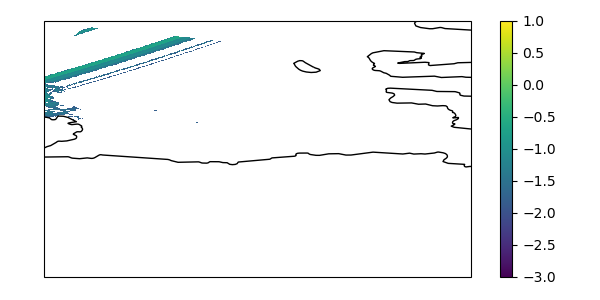

In [10]:
# ****Need to step through the makng of this modis data and plot each step to see where the problems are
data0 =  MODsst_xr
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(data0.x,data0.y,data0.values,vmin=-3,vmax=1,transform=cartopy.crs.epsg(3031))
ax.coastlines()
ax.set_ylim([-78, -72])
ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()

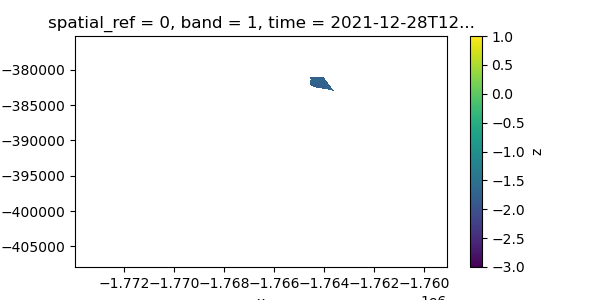

In [40]:
plt.figure(figsize=(6, 3))
# mask_mod = mod_scene.sea_surface_temperature[0,:,:].where(mod_scene.quality_level[0,:,:]>=4)
# (mod_scene.sea_surface_temperature[0,:,:]).plot.imshow(x='nj',y='ni')#,vmin=0,vmax=0.0008)
MODsst_xr_sub.plot.imshow(x='x',y='y',vmin=-3,vmax=1)

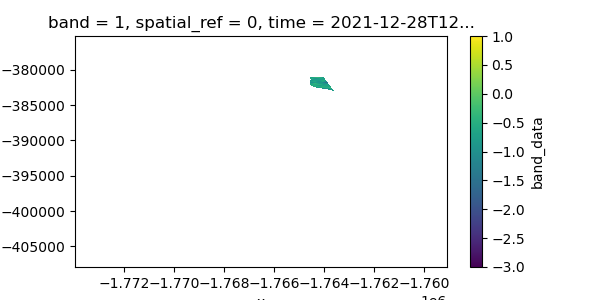

In [41]:
plt.figure(figsize=(6, 3))
# mask_mod = mod_scene.sea_surface_temperature[0,:,:].where(mod_scene.quality_level[0,:,:]>=4)
ls_scene = ls_scene.where(MODsst_xr_sub.notnull(),np.nan)
ls_scene.plot.imshow(x='x',y='y',vmin=-3,vmax=1)

In [13]:
box_x = [lonboundsC[0],lonboundsC[0],lonboundsC[1],lonboundsC[1],lonboundsC[0]]
box_y = [latboundsC[0],latboundsC[1],latboundsC[1],latboundsC[0],latboundsC[0]]

box_px = [bbox[0][0],bbox[3][0],bbox[2][0],bbox[1][0],bbox[0][0]]
box_py = [bbox[0][1],bbox[3][1],bbox[2][1],bbox[1][1],bbox[0][1]]

xp, yp = polygon.exterior.xy

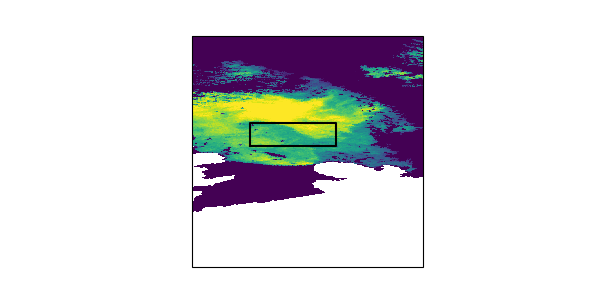

In [35]:
data0 = mod_scene.sea_surface_temperature[0,:,:]-273.15
data0 = data0.where((data0.lat<=-72) & (data0.lon<=-109))
data0 = data0.dropna(dim='nj', how='all')
data0 = data0.dropna(dim='ni', how='all')

plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolormesh(data0.lon,data0.lat,data0.values,vmin=-2,vmax=0,transform=ccrs.PlateCarree())
ax.plot(box_x,box_y,color='k',transform=ccrs.PlateCarree())
# ax.coastlines()
ax.set_ylim([-76, -72])
ax.set_xlim([-114,-110])
plt.show()

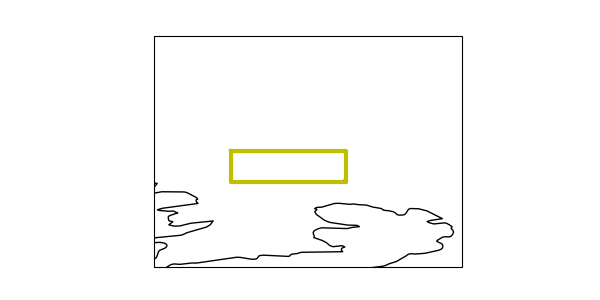

In [29]:
data0 = ls_scene
# da = xr.ones_like(data0)

plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
cb = ax.pcolormesh(data0.x,data0.y,data0.values,transform=cartopy.crs.epsg(3031)) 

# LatboundsC
ax.plot(box_x,box_y,color='k',transform=ccrs.PlateCarree())
# From bbox
ax.plot(box_px,box_py,color='r',transform=cartopy.crs.epsg(3031))
# From polygon.exterior.xy
ax.plot(xp, yp, color='y', linewidth=3, transform=cartopy.crs.epsg(3031))
ax.coastlines()

ax.set_ylim([-75, -72])
ax.set_xlim([-114,-110])
plt.show()

In [33]:
ls_scene = xr.open_dataset(lsatfiles[0],engine='rasterio')
ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
ls_scene = ls_scene['band_data'].sel(band=1)

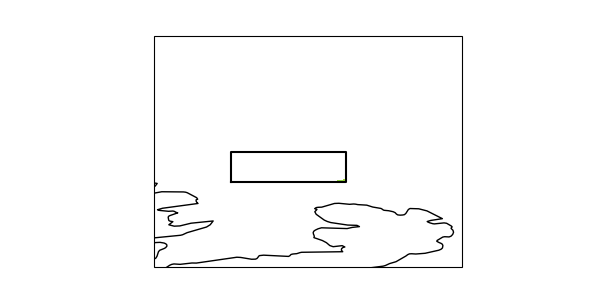

In [21]:
# Plot Landsat SST 
data0 = ls_scene
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
cb = ax.pcolormesh(data0.x,data0.y,data0.values,vmin=-8,vmax=0,transform=cartopy.crs.epsg(3031)) 
ax.plot(box_x,box_y,color='k',transform=ccrs.PlateCarree())
ax.coastlines()

ax.set_ylim([-75, -72])
ax.set_xlim([-114,-110])
plt.show()
# cbar = plt.colorbar(cb)
# plt.tight_layout()

In [ ]:
# Plot MODIS SST
data0 = mod_scene.sea_surface_temperature[0,:,:]
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
# cb = ax.pcolormesh(data0.lon,data0.lat,data0.values,vmin=240,vmax=274,transform=ccrs.PlateCarree()) 
cb = ax.pcolormesh(data0.lon,data0.lat,data0.values,vmin=268,vmax=274,transform=ccrs.PlateCarree()) 
ax.coastlines()

# # Convert the Shapely polygon to a format suitable for Cartopy
# feature1 = ShapelyFeature([final_polygon], ccrs.PlateCarree(), facecolor='green', edgecolor='black', alpha=0.4)
# # Add the polygon to the axes
# ax.add_feature(feature1)

# feature2 = ShapelyFeature([lsatpoly], ccrs.PlateCarree(), facecolor='white', edgecolor='white', alpha=0.4,zorder=2)
# # Add the polygon to the axes
# ax.add_feature(feature2)

# ax.set_ylim([-90, -55])
# ax.set_xlim([-180,-62.5])
ax.set_ylim([-75, -72])
ax.set_xlim([-107,-100])
cbar = plt.colorbar(cb)
# plt.tight_layout()

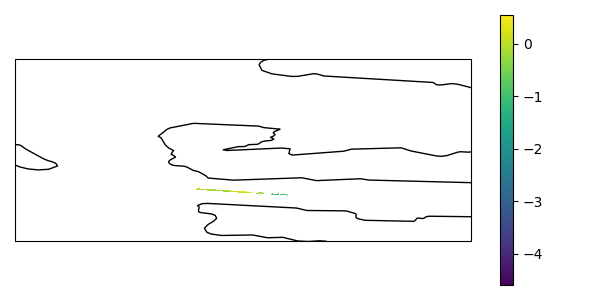

In [68]:
# For [2:3], plot water vapor data ***need to comment out the delete code above for this to work
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(xs1,ys1,ls_scene,transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_ylim([-74, -72.0])
ax.set_xlim([-105,-100])
# ax.set_ylim([-78, -72])
# ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()

In [35]:
# # Plot MODIS SST example - Cosgrove
# mod_reproj = MODsst_xr.rio.reproject("EPSG:4326")

# moddt = mod_reproj.sel(y=slice(-73.3,-73.6),x=slice(-105,-100))

# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# cb = ax.pcolormesh(moddt.x,moddt.y,moddt,vmin=-2.0,vmax=0.6,transform=ccrs.PlateCarree())
# plt.plot([-103.0,-102.0,-102.0,-103.0,-103.0],[-73.5,-73.5,-73.42,-73.42,-73.5],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
# ax.set_ylim([-73.8 , -73.1])
# ax.set_xlim([-103.9,-101.5])
# cbar = plt.colorbar(cb)
# plt.tight_layout()

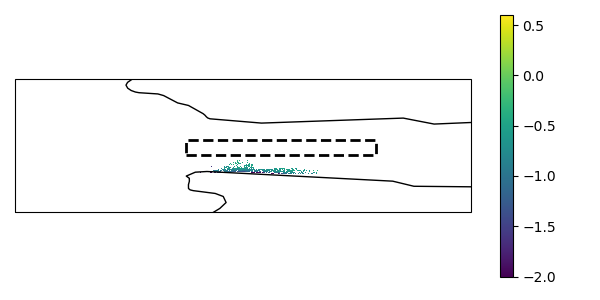

In [93]:
# # Plot Landsat SST example
# ls_reproj = ls_scene.rio.reproject("EPSG:4326")
# lsdt = ls_reproj.sel(band=1,y=slice(-73.3,-73.6),x=slice(-105,-100)).band_data

# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# cb = ax.pcolormesh(lsdt.x,lsdt.y,lsdt,vmin=-2.0,vmax=0.6,transform=ccrs.PlateCarree())
# plt.plot([-103.0,-102.0,-102.0,-103.0,-103.0],[-73.5,-73.5,-73.42,-73.42,-73.5],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
# ax.set_ylim([-73.8 , -73.1])
# ax.set_xlim([-103.9,-101.5])
# cbar = plt.colorbar(cb)
# # cbar.set_clim(-1, -6) # set limits of color map
# plt.tight_layout()

## Calculate calibration bias and trend
Uses a [RANSAC regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html), but provides comparisons to an Ordinary Least Squares regression calculation from statsmodel of the same parameters.

In [24]:
# Read in paired MODIS/Landsat data created above
surf_temp = 'SST'
thresh = -2.5
mod_sst_thresh = -1.9

# For Cosgrove region
if surf_temp=='LST':
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_LST_Cosgrove_20241128' #20240310
    df1 = pd.read_pickle(out_df)
    lsat_mod_df_C = df1
else:   
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Cosgrove_20250205' #20240303
    # out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Cosgrove_thresh_20241128' #20240303
    df1 = pd.read_pickle(out_df)
    # out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Cosgrove_20250205_2' 
    # df2 = pd.read_pickle(out_df)
    # lsat_mod_df_C = pd.concat([df1,df2])
    lsat_mod_df_C = df1

lsat_mod_df_C = lsat_mod_df_C[lsat_mod_df_C['MODIS_SST']>=mod_sst_thresh]
lsat_mod_df_C = lsat_mod_df_C[lsat_mod_df_C[f'L8_{surf_temp}']>=thresh]
lsat_mod_df_C = lsat_mod_df_C[lsat_mod_df_C['MODIS_pix']>=1000]

print(f'Original # matchups at Cosgrove: {lsat_mod_df_C[lsat_mod_df_C.MODIS_SST.notna()].shape[0]}')

# For Dotson polynya region
if surf_temp=='LST':
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_LST_Dotson_20241128' #20240310
    df5 = pd.read_pickle(out_df)
    lsat_mod_df_D = df5
else:
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Dotson_20241128' #20240303_1 & _2
    # out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Dotson_thresh_20241128' 
    df5 = pd.read_pickle(out_df)
    lsat_mod_df_D = df5

# lsat_mod_df_n = lsat_mod_df_D
lsat_mod_df_D = lsat_mod_df_D[lsat_mod_df_D['MODIS_SST']>=mod_sst_thresh]
lsat_mod_df_D = lsat_mod_df_D[lsat_mod_df_D[f'L8_{surf_temp}']>=thresh]
lsat_mod_df_D = lsat_mod_df_D[lsat_mod_df_D['MODIS_pix']>=1000]

print(f'Original # matchups at Dotson: {lsat_mod_df_D[lsat_mod_df_D.MODIS_SST.notna()].shape[0]}')

# For Burke region
if surf_temp=='LST':
    print ("no Burke yet")
    # out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_LST_Burke_20240310' #20240310
    # df9 = pd.read_pickle(out_df)
    # lsat_mod_df_B = df9
else:
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Burke_20241128'
    # out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Burke_thresh_20241128' 
    df9 = pd.read_pickle(out_df)
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Burke_20241128_2' 
    df10 = pd.read_pickle(out_df)
    lsat_mod_df_B = pd.concat([df9,df10])
    # lsat_mod_df_B = df9
    
    # lsat_mod_df_n = lsat_mod_df_B
    lsat_mod_df_B = lsat_mod_df_B[lsat_mod_df_B['MODIS_SST']>=mod_sst_thresh]
    lsat_mod_df_B = lsat_mod_df_B[lsat_mod_df_B[f'L8_{surf_temp}']>=thresh]
    lsat_mod_df_B = lsat_mod_df_B[lsat_mod_df_B['MODIS_pix']>=1000]

    print(f'Original # matchups at Burke: {lsat_mod_df_B[lsat_mod_df_B.MODIS_SST.notna()].shape[0]}')

# Concatenate data from both regions
if surf_temp=='LST':
    lsat_mod_df_n = pd.concat([lsat_mod_df_C,lsat_mod_df_D]) 
    print(f'Num. good matchups at Cosgrove: {lsat_mod_df_C[lsat_mod_df_C.MODIS_SST.notna()].shape[0]}, at Dotson: {lsat_mod_df_D[lsat_mod_df_D.MODIS_SST.notna()].shape[0]}')
else:
    lsat_mod_df_n = pd.concat([lsat_mod_df_B,lsat_mod_df_C,lsat_mod_df_D]) 
    lsat_mod_df_bc = pd.concat([lsat_mod_df_B,lsat_mod_df_C]) 
    lsat_mod_df_cd = pd.concat([lsat_mod_df_C,lsat_mod_df_D])
    lsat_mod_df_bd = pd.concat([lsat_mod_df_B,lsat_mod_df_D])
    print(f'Num. good matchups at Cosgrove: {lsat_mod_df_C[lsat_mod_df_C.MODIS_SST.notna()].shape[0]}, at Dotson: {lsat_mod_df_D[lsat_mod_df_D.MODIS_SST.notna()].shape[0]}, at Burke: {lsat_mod_df_B[lsat_mod_df_B.MODIS_SST.notna()].shape[0]}')

Original # matchups at Cosgrove: 23
Original # matchups at Dotson: 37
Original # matchups at Burke: 30
Num. good matchups at Cosgrove: 23, at Dotson: 37, at Burke: 30


In [22]:
sum_n = lsat_mod_df_n[lsat_mod_df_n.DateTime.dt.month.isin([9,10,11,12,1,3])]
shld_n = lsat_mod_df_n[lsat_mod_df_n.DateTime.dt.month.isin([2])]
sum_c = lsat_mod_df_C[lsat_mod_df_C.DateTime.dt.month.isin([9,10,11,12,1,3])]
sum_bc = lsat_mod_df_bc[lsat_mod_df_bc.DateTime.dt.month.isin([9,10,11,12,1,3])]
shld_bc = lsat_mod_df_bc[lsat_mod_df_bc.DateTime.dt.month.isin([2])]
sum_bd = lsat_mod_df_bd[lsat_mod_df_bd.DateTime.dt.month.isin([9,10,11,12,1,3])]
shld_bd = lsat_mod_df_bd[lsat_mod_df_bd.DateTime.dt.month.isin([2])]
sum_cd = lsat_mod_df_cd[lsat_mod_df_cd.DateTime.dt.month.isin([9,10,11,12,1,3])]
shld_cd = lsat_mod_df_cd[lsat_mod_df_cd.DateTime.dt.month.isin([2])]

In [15]:
# ***check all the february images to see if we need to add a threshold of 2.0C or cut images or if the issue is clouds???
# shld
look = lsat_mod_df_C.sort_values('DateTime')
look.tail(47)

,DateTime,MODIS_filename,MODIS_SST,MODIS_pix,L8_filename,L8_SST,L8_pix,time_dif
4,2021-11-10 14:58:00,20211110142001-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-1.829401,2100,LC08_L1GT_002112_20211110_20211117_02_T2_14580...,-3.271773,2100,0 days 00:37:59
35,2021-12-01 15:16:31,20211201143501-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-1.127219,310196,LC08_L1GT_005112_20211201_20211209_02_T2_15163...,-1.450554,310196,0 days 00:41:30
16,2021-12-03 15:04:09,20211203093501-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-1.709985,44381,LC08_L1GT_003112_20211203_20211209_02_T2_15040...,-2.239465,44381,0 days 00:39:09
17,2021-12-19 15:04:07,20211219142501-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-1.392790,14794,LC08_L1GT_003112_20211219_20211223_02_T2_15040...,-1.352080,14794,0 days 00:39:06
44,2021-12-24 15:22:38,20211224130501-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-0.383196,47087,LC08_L1GT_006112_20211224_20211230_02_T2_15223...,-0.445990,47087,0 days 00:42:37
60,2021-12-26 07:03:50,20211226051001-JPL-L2P_GHRSST-SSTskin-MODIS_A-...,-1.065328,99646,LC08_L1GT_157132_20211226_20211229_02_T2_07035...,-0.957198,99646,0 days 00:13:49
6,2021-12-28 14:57:53,20211228141500-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,0.083235,80925,LC08_L1GT_002112_20211228_20220105_02_T2_14575...,0.350638,80925,0 days 00:57:07
63,2022-01-02 07:09:59,20220102052001-JPL-L2P_GHRSST-SSTskin-MODIS_A-...,-0.712834,146769,LC08_L1GT_158132_20220102_20220105_02_T2_07095...,-1.858119,146769,0 days 00:14:58
36,2022-01-02 15:16:24,20220102143501-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-0.964913,6232,LC08_L1GT_005112_20220102_20220113_02_T2_15162...,-1.471486,6232,0 days 00:41:23
56,2022-01-04 06:57:37,20220104051000-JPL-L2P_GHRSST-SSTskin-MODIS_A-...,-1.011006,17732,LC08_L1GT_156132_20220104_20220114_02_T2_06573...,-2.353019,17732,0 days 00:12:37


In [25]:
# Orthoganal Regression 
if surf_temp=='LST':
    data0 = lsat_mod_df_n
else:
    data0 = lsat_mod_df_n

# Original data
x_original = np.array(data0[f'L8_{surf_temp}'])
y_original = np.array(data0['MODIS_SST'])

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model
linear = Model(linear_model)

# Create a RealData object using your DataFrame
data = RealData(x_original, y_original)

# Set up ODR with the model and data
odr = ODR(data, linear, beta0=[1., 0.])

# Run the regression
out = odr.run()

# Use the output
beta = out.beta
beta_err = out.sd_beta

# Print the summary
out.pprint()

# Predicting values using the ODR model
y_pred = linear_model(beta, x_original)

# Get R2
# Calculate Total Sum of Squares (SST)
y_mean = np.mean(y_original)
SST = np.sum((y_original - y_mean)**2)

# Calculate Residual Sum of Squares (SSR)
SSR = np.sum((y_original - y_pred)**2)

# Calculate R^2
R2 = 1 - (SSR / SST)
print("R^2:", np.around(R2,2))

Beta: [0.90940283 0.14750669]
Beta Std Error: [0.1071815  0.13516721]
Beta Covariance: [[0.05503404 0.06082501]
 [0.06082501 0.08752548]]
Residual Variance: 0.20874122879878468
Inverse Condition #: 0.03693481337270773
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.11


In [26]:
'''
BC - 
Beta: [ 0.90378583 -0.06248723]
Beta Std Error: [0.07534751 0.08238322]
Beta Covariance: [[0.06953183 0.05788218]
 [0.05788218 0.08312342]]
Residual Variance: 0.08164960521001896
Inverse Condition #: 0.058329464999314615
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.69

BD - 
Beta: [ 0.82391438 -0.16952937]
Beta Std Error: [0.06711189 0.07883443]
Beta Covariance: [[0.06475329 0.06413458]
 [0.06413458 0.08935003]]
Residual Variance: 0.06955640773835649
Inverse Condition #: 0.04444761930496278
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.64

CD - 
Beta: [ 0.9383582  -0.09971697]
Beta Std Error: [0.06650392 0.07344817]
Beta Covariance: [[0.07270212 0.06362785]
 [0.06362785 0.08867772]]
Residual Variance: 0.060834143157298376
Inverse Condition #: 0.05404261550750983
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.74

BCD -
Beta: [ 0.89202846 -0.10567608]
Beta Std Error: [0.05672964 0.06396993]
Beta Covariance: [[0.04569846 0.04137869]
 [0.04137869 0.05810765]]
Residual Variance: 0.07042362684151367
Inverse Condition #: 0.05164901094886521
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.69
'''

'\nBC - \nBeta: [ 0.90378583 -0.06248723]\nBeta Std Error: [0.07534751 0.08238322]\nBeta Covariance: [[0.06953183 0.05788218]\n [0.05788218 0.08312342]]\nResidual Variance: 0.08164960521001896\nInverse Condition #: 0.058329464999314615\nReason(s) for Halting:\n  Sum of squares convergence\nR^2: 0.69\n\nBD - \nBeta: [ 0.82391438 -0.16952937]\nBeta Std Error: [0.06711189 0.07883443]\nBeta Covariance: [[0.06475329 0.06413458]\n [0.06413458 0.08935003]]\nResidual Variance: 0.06955640773835649\nInverse Condition #: 0.04444761930496278\nReason(s) for Halting:\n  Sum of squares convergence\nR^2: 0.64\n\nCD - \nBeta: [ 0.9383582  -0.09971697]\nBeta Std Error: [0.06650392 0.07344817]\nBeta Covariance: [[0.07270212 0.06362785]\n [0.06362785 0.08867772]]\nResidual Variance: 0.060834143157298376\nInverse Condition #: 0.05404261550750983\nReason(s) for Halting:\n  Sum of squares convergence\nR^2: 0.74\n\nBCD -\nBeta: [ 0.89202846 -0.10567608]\nBeta Std Error: [0.05672964 0.06396993]\nBeta Covarianc

In [27]:
# # Calculate p-value for ODR **does not have a lot of meaning

# # P-value
# # Initialize variables for bootstrapping
# n_boots = 1000  # number of bootstrap samples
# boot_coeffs = []  # to store coefficients from each bootstrap
# r2_values = [] # to store R2 from each bootstrap

# # Bootstrapping
# for _ in range(n_boots):
#     # Create a bootstrap sample with replacement
#     indices = np.random.choice(range(len(x_original)), size=len(x_original), replace=True)
#     x_boot = x_original[indices]
#     y_boot = y_original[indices]

#     # Fit ODR on the bootstrap sample
#     data_boot = RealData(x_boot, y_boot)
#     odr_boot = ODR(data_boot, Model(linear_model), beta0=[1., 0.])
#     out_boot = odr_boot.run()
#     boot_coeffs.append(out_boot.beta)  # Store the coefficients
    
#     # Predicting values using the ODR model
#     y_pred_boot = linear_model(beta, x_original)
    
#     # Calculate Total Sum of Squares (SST)
#     y_mean = np.mean(y_boot)
#     SST = np.sum((y_boot - y_mean)**2)

#     # Calculate Residual Sum of Squares (SSR)
#     SSR = np.sum((y_original - y_pred_boot)**2)

#     # Calculate R^2
#     r2_boot = 1 - (SSR / SST)
#     r2_values.append(r2_boot)

# # Convert to DataFrame for analysis
# boot_coeffs_df = pd.DataFrame(boot_coeffs, columns=['Slope', 'Intercept'])

# # Calculate p-values for coefficients
# # Here, we're comparing to the original model's coefficients (beta)
# p_values = []
# for col in boot_coeffs_df.columns:
#     p = np.sum(boot_coeffs_df[col] >= beta[list(boot_coeffs_df.columns).index(col)]) / n_boots
#     p_values.append(p)
    
# # Here, we're comparing to the original model's R2
# p_valuesR = np.sum(r2_values >= R2) / n_boots

# print("P-values:", p_values)
# print("P-values for r2:", p_valuesR)

At 95% confidence interval: 0.91+/-0.21, 0.15+/-0.26, n=90


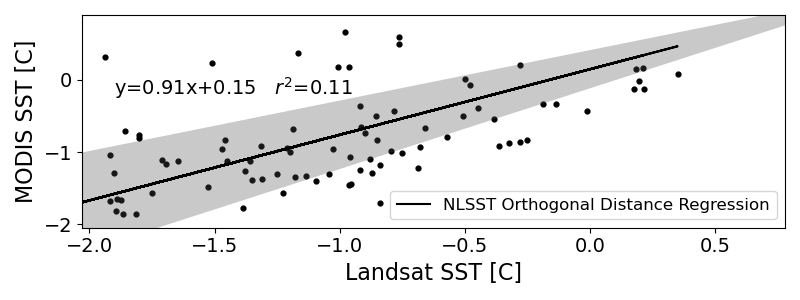

In [28]:
# Plot regression
beta_mdn = [beta[0]-beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_mup = [beta[0]+beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_bdn = [beta[0]-beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
beta_bup = [beta[0]+beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
print(f'At 95% confidence interval: {np.around(beta[0],2)}+/-{np.around(beta_err[0]*1.96,2)}, {np.around(beta[1],2)}+/-{np.around(beta_err[1]*1.96,2)}, n={y_pred.shape[0]}')
xfill = np.array([-4.3,0.9])

fig, ax = plt.subplots(figsize=(8, 3))
ax.tick_params(labelsize=14)

plt.scatter(x_original, y_original, s=12,color='k')
if surf_temp=='LST':
    plt.plot(x_original, y_pred, color='k', label='LST Orthogonal Distance Regression')
    plt.legend(loc='upper left',fontsize=14)
else:
    plt.plot(x_original, y_pred, color='k', label='NLSST Orthogonal Distance Regression')
    plt.legend(loc='lower right',fontsize=12)
# plt.fill_between(xfill, linear_model(beta_mdn, xfill), linear_model(beta_bup, xfill),alpha=0.3, facecolor='0.3')
plt.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.3, facecolor='0.3')

if surf_temp=='LST':
    plt.text(-2.85,-0.55,f'y={np.around(beta[0],2)}x+{np.around(beta[1],2)}   $r^2$={np.around(R2,2)}',fontsize=14)
    plt.xlim([-4.2,-0.65])
    plt.ylim([-2.05,0.5])
else: 
    plt.text(-1.9,-0.2,f'y={np.around(beta[0],2)}x+{np.around(beta[1],2)}   $r^2$={np.around(R2,2)}',fontsize=14)
    plt.xlim([-2.03,0.78])
    plt.ylim([-2.05,0.9]) 
plt.xlabel('Landsat SST [C]',fontsize=16)
plt.ylabel('MODIS SST [C]',fontsize=16)
plt.tight_layout()

In [29]:
# Orthoganal Regression for SST only
dataframes = [
    ('Combined', lsat_mod_df_n),
    ('Burke', lsat_mod_df_B),
    ('Cosgrove', lsat_mod_df_C),
    ('Dotson', lsat_mod_df_D),
]

# Dictionary to store the results from each DataFrame
odr_results = {}

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model object
linear = Model(linear_model)

# Loop over each DataFrame
for df_name, data0 in dataframes:
    print(f"\n=== Processing {df_name} ===")
    
    # Original data
    x_original = np.array(data0[f'L8_{surf_temp}'])
    y_original = np.array(data0['MODIS_SST'])
    
    # Create a RealData object using your DataFrame
    data = RealData(x_original, y_original)
    
    # Set up ODR with the model and data, providing an initial guess
    odr = ODR(data, linear, beta0=[1., 0.])
    
    # Run the regression
    out = odr.run()
    
    # Retrieve best-fit parameters and their std. dev.
    beta = out.beta
    beta_err = out.sd_beta
    
    # Print the summary
    out.pprint()
    
    # Predicting values using the ODR model
    y_pred = linear_model(beta, x_original)
    
    # Get R2
    # Calculate Total Sum of Squares (SST)
    y_mean = np.mean(y_original)
    SST = np.sum((y_original - y_mean)**2)
    
    # Calculate Residual Sum of Squares (SSR)
    SSR = np.sum((y_original - y_pred)**2)
    
    # Calculate R^2
    R2 = 1 - (SSR / SST)
    print("R^2:", np.around(R2,2))
    
    # Print R^2
    print(f"{df_name} R^2:", np.around(R2, 2))
    
    # Store results in a dictionary for later use (plotting, etc.)
    odr_results[df_name] = {
        'beta': beta,
        'beta_err': beta_err,
        'R2': R2,
        'x_original': x_original,
        'y_original': y_original,
        'y_pred': y_pred
    }


=== Processing Combined ===
Beta: [0.90940283 0.14750669]
Beta Std Error: [0.1071815  0.13516721]
Beta Covariance: [[0.05503404 0.06082501]
 [0.06082501 0.08752548]]
Residual Variance: 0.20874122879878468
Inverse Condition #: 0.03693481337270773
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.11
Combined R^2: 0.11

=== Processing Burke ===
Beta: [ 0.79815811 -0.13035763]
Beta Std Error: [0.10318946 0.12097794]
Beta Covariance: [[0.12205359 0.11753979]
 [0.11753979 0.16776148]]
Residual Variance: 0.08724089823437453
Inverse Condition #: 0.047430325266429284
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.6
Burke R^2: 0.6

=== Processing Cosgrove ===
Beta: [1.59965869 1.57656969]
Beta Std Error: [0.42795614 0.59424281]
Beta Covariance: [[0.75653541 0.99321539]
 [0.99321539 1.45867517]]
Residual Variance: 0.2420857774653627
Inverse Condition #: 0.022431962721761057
Reason(s) for Halting:
  Sum of squares convergence
R^2: -0.34
Cosgrove R^2: -0.34

=== Processing Dot

At 95% confidence interval: 0.91+/-0.21, 0.15+/-0.26, n=90


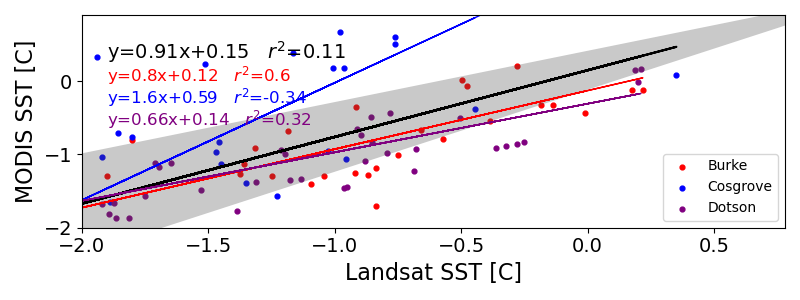

In [30]:
# Plot with all points and by region (Burke=r, Cosgrove=b, Dotson=g) - show with lsat_mod_df_n calculations for the line
beta_mdn = [odr_results['Combined']['beta'][0]-odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]-odr_results['Combined']['beta_err'][1]*1.96]
beta_mup = [odr_results['Combined']['beta'][0]+odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]-odr_results['Combined']['beta_err'][1]*1.96]
beta_bdn = [odr_results['Combined']['beta'][0]-odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]+odr_results['Combined']['beta_err'][1]*1.96]
beta_bup = [odr_results['Combined']['beta'][0]+odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]+odr_results['Combined']['beta_err'][1]*1.96]
a1 = np.around(odr_results['Combined']['beta'][0],2)
a2 = np.around(odr_results['Combined']['beta_err'][0]*1.96,2)
a3 = np.around(odr_results['Combined']['beta'][1],2)
a4 = np.around(odr_results['Combined']['beta_err'][1]*1.96,2)
a5 = odr_results['Combined']['y_pred'].shape[0]
a6 = np.around(odr_results['Combined']['R2'],2)
b1 = np.around(odr_results['Burke']['beta'][0],2)
b2 = np.around(odr_results['Burke']['beta_err'][1],2)
b3 = np.around(odr_results['Burke']['R2'],2)
c1 = np.around(odr_results['Cosgrove']['beta'][0],2)
c2 = np.around(odr_results['Cosgrove']['beta_err'][1],2)
c3 = np.around(odr_results['Cosgrove']['R2'],2)
d1 = np.around(odr_results['Dotson']['beta'][0],2)
d2 = np.around(odr_results['Dotson']['beta_err'][1],2)
d3 = np.around(odr_results['Dotson']['R2'],2)
print(f'At 95% confidence interval: {a1}+/-{a2}, {a3}+/-{a4}, n={a5}')
xfill = np.array([-4.3,0.9])


fig, ax = plt.subplots(figsize=(8, 3))
ax.tick_params(labelsize=14)

plt.scatter(np.array(lsat_mod_df_B[f'L8_{surf_temp}']), np.array(lsat_mod_df_B['MODIS_SST']), s=12,color='r', label='Burke')
plt.scatter(np.array(lsat_mod_df_C[f'L8_{surf_temp}']), np.array(lsat_mod_df_C['MODIS_SST']), s=12,color='b', label='Cosgrove')
plt.scatter(np.array(lsat_mod_df_D[f'L8_{surf_temp}']), np.array(lsat_mod_df_D['MODIS_SST']), s=12,color='purple', label='Dotson')

plt.plot(odr_results['Combined']['x_original'], odr_results['Combined']['y_pred'], color='k')
plt.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.3, facecolor='0.3')
plt.plot(odr_results['Burke']['x_original'], odr_results['Burke']['y_pred'], ls='-',linewidth=1,color='r')
plt.plot(odr_results['Cosgrove']['x_original'], odr_results['Cosgrove']['y_pred'], ls='-',linewidth=1,color='b')
plt.plot(odr_results['Dotson']['x_original'], odr_results['Dotson']['y_pred'], ls='-',linewidth=1,color='purple')

if surf_temp=='LST':
    plt.text(-2.25,-0.2,f'y={a1}x+{a3}   $r^2$={a6}',color='k',fontsize=14)
    plt.text(-2.25,-0.2,f'y={c1}x+{c2}   $r^2$={c3}',color='b',fontsize=12)
    plt.text(-2.25,-0.2,f'y={d1}x+{d2}   $r^2$={d3}',color='purple',fontsize=12)
    plt.xlim([-2.5,-1.4])
    plt.ylim([-2.05,0.0])
else: 
    plt.text(-1.9,0.3,f'y={a1}x+{a3}   $r^2$={a6}',color='k',fontsize=14)
    plt.text(-1.9,0.0,f'y={b1}x+{b2}   $r^2$={b3}',color='r',fontsize=12)
    plt.text(-1.9,-0.3,f'y={c1}x+{c2}   $r^2$={c3}',color='b',fontsize=12)
    plt.text(-1.9,-0.6,f'y={d1}x+{d2}   $r^2$={d3}',color='purple',fontsize=12)
    plt.xlim([-2.0,0.78])
    plt.ylim([-2.0,0.9]) 
    # plt.xlim([-4.0,2])
    # plt.ylim([-4.0,2])
plt.xlabel('Landsat SST [C]',fontsize=16)
plt.ylabel('MODIS SST [C]',fontsize=16)
plt.legend(loc='lower right',fontsize=10)
plt.tight_layout()

In [20]:
# Ordinary least squares regression between Landsat and MODIS SST matchups
resultC = sm.ols(formula="MODIS_SST ~ L8_SST", data=data0).fit()
print (resultC.summary())

                            OLS Regression Results                            
Dep. Variable:              MODIS_SST   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     30.67
Date:                Mon, 13 Jan 2025   Prob (F-statistic):           7.14e-07
Time:                        22:10:23   Log-Likelihood:                -32.681
No. Observations:                  62   AIC:                             69.36
Df Residuals:                      60   BIC:                             73.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7472      0.093     -8.030      0.0

In [117]:
# RANSAC Regression for atm corrected SST
ydata = 'MODIS_SST'
xdata = 'L8_SST'
forrsac = data0[[xdata,ydata]].dropna()
xC = np.reshape(forrsac[xdata].values,(forrsac[xdata].shape[0],1))
yC = np.reshape(forrsac[ydata].values,(forrsac[ydata].shape[0],1))
reg = RANSACRegressor(random_state=0).fit(xC,yC)
yLC = reg.predict(xC)
scoreC = reg.score(xC,yC)

lreg = LinearRegression().fit(xC,yLC)
print ('m = '+str(lreg.coef_[0][0]))
print ('b = '+str(lreg.intercept_[0]))
print ('score = '+str(scoreC))

m = 0.7096063427756417
b = -0.21682805666681204
score = 0.6979604281038205


In [23]:
# Permuation test for p-value pearson or RANSAC
# https://towardsdatascience.com/how-to-assess-statistical-significance-in-your-data-with-permutation-tests-8bb925b2113d

# Initialize variables
pR = []
x = xC
y = yC

# Choose number of permutations
p=10000

# Initialize permutation loop
for i in range(0,p):
    # Shuffle one of the features
    pS = copy.copy(y)
    random.shuffle(pS)
    # Computed permuted correlations and store them in pR
    reg = RANSACRegressor(random_state=0).fit(x,pS)
    pR.append(reg.score(x,pS))
#     pR.append(stats.pearsonr(xC,yLC)[0])

# Significance
p_val = len(np.where(np.abs(pR)>=np.abs(scoreC))[0])/np.float(p)
print (f'RANSAC p: {p_val}')

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [41]:
print (lreg.coef_[0])
print (lreg.intercept_[0])

[0.94872064]
-0.04331819711443452


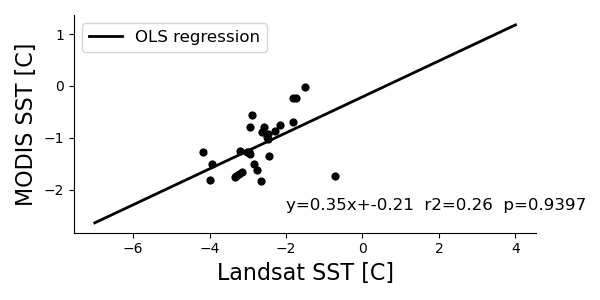

In [26]:
# Plot data points and RANSAC regression
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 3))
xi = np.arange(-7.0,5.0,1.0)

a1 = ax
a1.tick_params(labelsize=10)
a1.scatter(data0[xdata],data0[ydata],color='k',linewidth=0,s=35,label='_no label_')
# a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='r',linewidth=2,label='RANSAC regression')
# a1.scatter(xC,yLC,color='r',linewidth=0,s=35,label='_no label_')
a1.plot(xi,xi*resultC.params.L8_SST+resultC.params.Intercept,color='k',linewidth=2,label='OLS regression')
a1.text(-2.0,-2.4,f'y={np.around(resultC.params.L8_SST,2)}x+{np.around(resultC.params.Intercept,2)}  r2={np.around(resultC.rsquared,2)}  p={p_val}',fontsize=12)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
a1.set_ylim([-2.5,1])
a1.set_xlim([-2.7,1])
a1.set_xlabel('Landsat SST [C]',fontsize=16)
a1.set_ylabel('MODIS SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()

## Test to see if rioxarray reproject is causing issues

I noticed when I use rioxarray to reproject MODIS and Landsat to WGS84 (espg 4326)
that the x,y dimensions changed, which shouldn't happen. We need to keep the 
same spatial resolution and therefore dimensions. 

Here, I'm comparing the outputs of the Landsat/MODIS pair data from the method above where I immediately take the aggregate (without reprojection from espg 3031) and take the aggregate after I reproject to WGS84.

In [24]:
# Read in paired MODIS/Landsat data created above
out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230621_reproj'
df1 = pd.read_pickle(out_df)
out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230622_reproj'
df2 = pd.read_pickle(out_df)

df0 = pd.concat([df1,df2])

# Reran the first two, to check value differences after removing the reprojection step
out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230622'
df3 = pd.read_pickle(out_df)

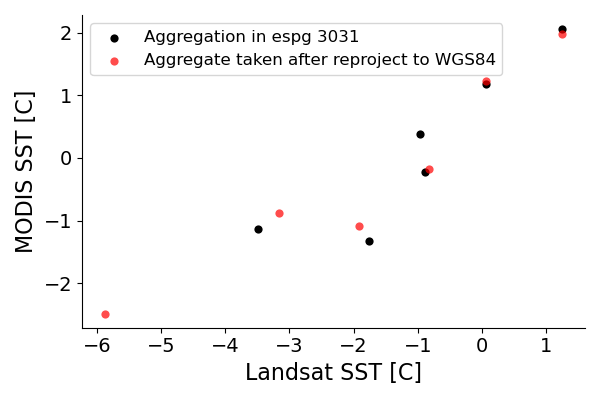

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 4))
xi = np.arange(-6.0,2.0,1.0)

data = df3  # Data all aggregated in espg 3031
data0 = df0  # Half of data is aggregated after reprojecting to espg 4236

a1 = ax
a1.tick_params(labelsize=14)
a1.scatter(data[Ldata],data[Mdata],color='k',linewidth=0,s=35,label='Aggregation in espg 3031') #'_no label_')
a1.scatter(data0[Ldata],data0[Mdata],color='r',linewidth=0,s=35,alpha=0.7,label='Aggregate taken after reproject to WGS84')
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_xlim([-5,1.5])
# a1.set_ylim([-1.8,2.0])
a1.set_ylabel('MODIS SST [C]',fontsize=16)
a1.set_xlabel('Landsat SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()

These points don't match up, so we need to worry about using rioxarray for reprojections...

# Landsat calibration using MODIS SST
Create matchups between Landsat and MODIS SST data near Cosgrove, West Antarctica
to produce a calibration for Landsat SSTs

In [1]:
# Import libraries and modules
%config InlineBackend.figure_format = 'svg'
%matplotlib widget
import pandas as pd
import xarray as xr
import geopandas as gpd
from datetime import date, timedelta, datetime
import numpy as np
import matplotlib.pylab as plt
from matplotlib import colors
from matplotlib.pylab import rcParams
import cartopy.crs as ccrs
import cartopy

import os
from cycler import cycler
import pyproj
from pyproj import Proj, transform
from sklearn.neighbors import BallTree
import pytz
import pygmt
import gc
import copy
import random
import statsmodels.formula.api as sm
import scipy.stats as stats
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
# from shapely.geometry.polygon import Polygon
from shapely.geometry import Point, Polygon
from pathlib import Path
import math
from scipy.odr import Model, RealData, ODR

import earthaccess

import warnings
warnings.filterwarnings('ignore')

In [2]:
#For color cycling in plots that is color blind friendly...make new ones at "I want hue" tools.medialab.sciences-po.fr/iwanthue
color_cycler = cycler(color=["#6777cf","#adba49","#c65ca0","#5fa042","#683287","#72ce7b","#c44a48","#45c7a9","#933c1d","#d0803f","#ac9239","#317c39"])
colorline_cycler = (cycler(color=["#75a141","#6c61b9","#bc4d45","#c1913d","#b85298","#4aa8e8"]) +
                 cycler(linestyle=['-','--',':','-.','-','--']))
rcParams['axes.prop_cycle'] = cycler('color', color_cycler)

## Build Landsat - MODIS SST matchups

In [3]:
# Set paths and important variables and Calibration region bounding box

basepath = Path('/home/jovyan/Landsat_SST_algorithm')
spacing = [990,-990] # 990m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
param = 'sea_surface_temperature'
size_threshold = 30

location = 1   # 0 and 1 are the Cosgrove and Dotson Polynya calibration areas, respectively
lst = 1        # 0 and 1 are for the Landsat SST and LST algorithms respectively

# Set location bounds
if location==1:
    pathdir = 'DotsonPolynya'
    latboundsC = [ -73.9 , -73.5 ] # Dotson polynya
    lonboundsC = [ -113 , -111.5 ]
    dfloc = 'Dotson'
elif location==0:
    pathdir = 'Cosgrove'
    latboundsC = [ -73.5 , -73.42 ] # near Cosgrove
    lonboundsC = [ -103.0 , -102.0 ]
    dfloc = 'Cosgrove'

# latboundsC = [ -69.9, -69.6 ] # Offshore NE Amundsen, didn't use cuz couldn't get a viable dataset
# lonboundsC = [ -99.2 , -98.4 ]

if lst==0:
    # For calibrated SST runs
    sstpath = basepath / f'Data/SST/MODcalib/{pathdir}/'
else:
    # For LST runs
    sstpath = basepath / f'Data/LST/Calibration/{pathdir}/'

In [4]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [5]:
def lsat_reproj(old_cs,new_cs,lbox):
    '''
    bbox comes out with the points out of order for making a polygon though pairs are correct. Order is 0,3,1,2 when done in normal projection. 
    Haven't tested for flipped grid.
    '''
    
    test_threshold = 0.5
    
    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)
    
    ULX,LRY,LRX,ULY = lbox

    [lULX,lLRX], [lULY,lLRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
    [cULX,cLRX], [cULY,cLRY] =  transform(outProj,inProj,[lULX,lLRX], [lULY,lLRY], always_xy=True)
    [lLLX,lURX], [lLLY,lURY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)
    [cLLX,cURX], [cLLY,cURY] =  transform(outProj,inProj,[lLLX,lURX], [lLLY,lURY], always_xy=True)

    if LRY>ULY:
        bbox = [(lULX,lLLY),(lLLX,lULY),(lLRX,lURY),(lURX,lLRY)]
        print('lsat_reproj flipped orientation')
    else:
        bbox = [(lULX,lULY),(lLLX,lLLY),(lLRX,lLRY),(lURX,lURY)]
        print('lsat_reproj normal orientation')

    checkbox = np.array([cULX,cULY,cLRX,cLRY])
    if np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY])) > test_threshold:
        print(f"Round-trip transformation error 1 of {np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY]))}")
    checkbox = np.array([cLLX,cLLY,cURX,cURY])
    if np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY])) > test_threshold:
        print(f"Round-trip transformation error 2 of {np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY]))}")
    print (f'bbox={bbox}')
    print (f'lbox={lbox}')
    print (f'checkbox={checkbox}')
    
    return bbox,checkbox

##########################

def crop_xarray_dataarray_with_polygon(dataarray, polygon):
    """
    Crop an xarray.DataArray using a polygon.
    
    Parameters:
    - dataarray: xarray.DataArray with x and y coordinates.
    - polygon: Shapely Polygon object defining the crop area.
    
    Returns:
    - Cropped xarray.DataArray.
    """
    # Generate a 2D array of shapely Point objects for each grid point
    lon, lat = np.meshgrid(dataarray.x.values, dataarray.y.values)
    points = np.vectorize(Point)(lon, lat)
    
    # Create a mask where points within the polygon are True
    mask_func = np.vectorize(polygon.contains)
    mask = mask_func(points)
    
    # Convert the mask to an xarray.DataArray
    mask_da = xr.DataArray(mask, dims=["y", "x"], coords={"y": dataarray.y, "x": dataarray.x})
    
    # Apply the mask to the dataarray, cropping to the polygon
    # Use where method with drop=True to drop values outside the polygon
    cropped_dataarray = dataarray.where(mask_da, drop=True)
    
    return cropped_dataarray

##########################

def subset_img(da,polarx,polary):
    '''
    ***Only works for square grid cropping along the orientation of the grid (not when cropping along lat/lon in a 3031 grid
    
    Subset image in xarray to desired coordinates. Because Landsat polar stereo projection can be oriented
    in many different directions, when coordinates to subset an image are reprojected from lat/lon they may get 
    flipped for which is larger in the pair. This function checks to make sure we are getting a proper subset and 
    avoids 0 pixels on the x or y axis. 
    
    Note: Input shape dimensions and dataarray v. dataset changes things so input needs to be a dataarray w 
          2 dimensions (x,y)
    
    Input:
    da = xarray DataArray to be subset
    polarx = x coordinates to subset by in polar stereographic projection
    polary = y coordinates to subset by in polar stereographic projection
    
    Output:
    ls_sub = subset xarray DataArray
    
    '''
    # ***Landsat shape dimensions are one fewer than they are for LandsatCalibration [0,1] not [1,2], no .to_array() or Band
    ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))

    # Check for right dimensions because y order changes sometimes
    if (ls_sub.x.shape[0]==0) & (ls_sub.y.shape[0]==0):
        print ('L8 x and y shapes are 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
    elif ls_sub.y.shape[0]==0:
        print ('L8 y shape is 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1]))
    elif ls_sub.x.shape[0]==0:
        print ('L8 x shape is 0')
        ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[1],polarx[0]))
    print(da.shape)
    print(ls_sub.shape)
    
    return ls_sub
    
##########################

def crosses_idl(coords):
    '''
    Determine if the set of coordinates crosses the International Dateline in a way that will mess up the creation of a polygon
    
    Variables:
    coords = list of lon, lat tuples
    
    Output:
    True or False
    '''
    
    for (lon1, lat1), (lon2, lat2) in zip(coords, coords[1:]):
        if abs(lon1 - lon2) >= 180:
            return True
    return False

##########################

# Preprocess to add time dimension and the file name to open_mfdataset for landsat using the filename
def add_time_dim(ds):
    lstr = ds.encoding["source"].split("LC0",1)[1]
    times = pd.to_datetime(lstr[14:22]+lstr[38:44], format='%Y%m%d%H%M%S')
    idee = ds.encoding["source"].split("/")[8][:-4] # The first number depends on how many subdirectories the file is in
    return ds.assign_coords(time=times,ID=idee)

In [6]:
def find_MODIS(lonboundsC,latboundsC,ls_scene):
    '''
    Finds the MODIS scene most closely coincident to a Landsat scene
    Uses full Landsat scene extent, not cropped
    
    Variables: 
    ls_scene = xarray for one Landsat scene
    
    Outputs:
    mod_scene = xarray of MODIS SST image coincident in time with the Landsat scene
    granules[ind]['umm']['GranuleUR'] = modis file name
    min_time = the time difference between the Landsat image acquisition and chosen MODIS image
    
    **not done, Differences from NLSST: 0.0 used as percent_dif requiring 100% overlap between MODIS and Landsat here since the subset area is so small
    '''
    
    mbox = (lonboundsC[0],latboundsC[0],lonboundsC[1],latboundsC[1]) #east, south,west,north
    lsatpoly = Polygon([(lonboundsC[0],latboundsC[1]),(lonboundsC[0],latboundsC[0]),(lonboundsC[1],latboundsC[0]),(lonboundsC[1],latboundsC[1]),(lonboundsC[0],latboundsC[1])])

    # Get date/time for Landsat image and search for corresponding MODIS imagery  
    ls_time = pd.to_datetime(ls_scene.time.values)
    calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
    end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')
    
    # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
    granules = earthaccess.search_data(
        short_name='MODIS_T-JPL-L2P-v2019.0',
        bounding_box=mbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules2 = earthaccess.search_data(
        short_name='MODIS_A-JPL-L2P-v2019.0', #MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_NIGHTTIME_V2019.0
        bounding_box=mbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules = granules + granules2
    print (f'{len(granules)} TOTAL MODIS granules')

    # Accept only MODIS granules that overlap at least a perscribed amount with Landsat, in this case 100% => percent_dif=0.0
    best_grans = []
    for granule in granules:
        try:
            granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
        except Exception as error:
            print(error)
            continue
            # Would love to raise an exception for a valueerror except for GEOSError
        for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
            try:
                # Extract points, make into a polygon
                map_points = [(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']]
                pgon = Polygon(map_points)
                percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
                # If the polygon covers the landsat area, check to make sure it doesn't cross the international date line with a messed up polygon (these are searched wrong in earthaccess so probably need adjustment there)
                if percent_dif == 0.0:
                    if crosses_idl(map_points):
                        print (f'A granule has messed up polygon that likely crosses the International DateLine')
                    else:
                        best_grans.append(granule)
                        continue
            except Exception as error:
                print(error)
                # Would love to raise an exception for a valueerror except for GEOSError
    print(f'len(best_grans) remaining MODIS granules')

    # Find MODIS image closest in time to each Landsat image
    # Make Landsat datetime timezone aware (UTC)
    Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
    ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(ls_time))))
    time_dif = abs(Mdates[ind] - pytz.utc.localize(pd.to_datetime(ls_time)))
    print(f'Time difference between MODIS and Landsat: {time_dif}')

    mod_scene = xr.open_dataset(earthaccess.open(best_grans[ind:ind+1])[0])
    mod_scene = mod_scene.rio.write_crs("epsg:4326", inplace=True) 
    
    return mod_scene, granules[ind]['umm']['GranuleUR'],time_dif

##########################  

def get_wv(ls_scene,mod07,spacing,param):
    '''
    ***This is copied in LandsatCalibration, modifications have been made but some may tranfer
    
    Create MODIS files aligned and subsampled to Landsat
    
    Variables:
    ls_scene = xarray dataset of a Landsat scene
    mod07 = xarray datarray with MODIS data
    spacing = list of desired spatial resolution of output data from the alignment of MODIS to Landsat in y and x (e.g.,[300,-300])
    param = string for desired dataset from MODIS file
    
    Output:
    WV_xr = xarray dataarray of Landsat aligned and upsampled modis data from desired dataset
    
    Differences from NLSST: scene is not a parameter (used for test_gridcoords), SST gets extracted differently into data/lat/lon
    
    '''
    # Read in desired variables and paths
    
    uniqWV = []

    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]
    LRX = ls_scene.x[-1]
    LRY = ls_scene.y[-1] 
    box = [ULX,LRX,ULY,LRY]
    
    #Extract desired datasets from MODIS file
    if param == 'sea_surface_temperature': 
        data = mod07[0,:,:]
        lat, lon = mod07.lat, mod07.lon
    else: 
        data = mod07[param]
        lat, lon = mod07.Latitude, mod07.Longitude    

    # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
    indiciesMOD,lines,samples = MODISlookup(mod07,ls_scene,box,spacing)

    # Align MODIS SST to Landsat on slightly upsampled grid # have the option to output `uniqImgWV` if want to know range of data
    dataOutWV_xr = alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing)

    # Resample MODIS to Landsat resolution and interpolate with B-spline
    # Output of shape fits and need to adjust x and y coords cuz are wrong
    ups_factor = 30/spacing[0]
    WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k') # ,interpolation='b' if prefer to interpolate with bspline but don't think it is useful here

    # Put into Xarray
    latnew = ls_scene.y[:WV_upsample.shape[0]].values
    lonnew = ls_scene.x[:WV_upsample.shape[1]].values
    if dataOutWV_xr.latitude[0]!=latnew[0]:
        print('Aligned y dim needs to start with the same coordinate as ls_scene')
    if dataOutWV_xr.longitude[0]!=lonnew[0]:
        print('Aligned x dim needs to start with the same coordinate as ls_scene')
    
    WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})
    WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
    WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})
    WV_xr = WV_xr.set_index(x='x')
    WV_xr = WV_xr.set_index(y='y')

#     #Append WV values
#     uniqWV.append(uniqImgWV)
    
#     try:
#         # Min and max MODIS values for a scene
#         maxi =[]
#         mini =[]
#         for m in uniqWV:
#             maxi.append(max(m))
#             mini.append(min(m))

#         print (f'Max {param}: {np.max(maxi)}, min: {np.min(mini)}')
#     except:
#         print (f'Max {param}: {np.nan}, min: {np.nan}')
    
    return WV_xr
           
##########################           

def MODISlookup (mod07,ls_scene,box,spacing):
    '''
    Look up atmospheric consituents from MODIS product for each Landsat pixel
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
    # and Shane Grigsby

    Variables:    
    mod07 = xarray with MODIS data with crs 4326 assigned
    ls_scene =  Landsat xarray DataArray
    box = list with [left easting,right easting,top northing,bottom northing]
    spacing = desired pixel size for extraction, list of [east/west, north/south] 
          (recommend choosing a number that allows for fast calculations and even division by 30)

    Output:
    indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    x1,y1 = x and y coordinates for grid
    
    Differences from NLSST: lat/lon variables named differently in SST vs WV files, no interpolation,
    test_gridcoords does not use `scene`, don't need to output lat/lon because do not interpolate and make 
    new ones
    
    '''
    test_threshold = 5 
    
    lat, lon = mod07.lat, mod07.lon # Different for SST vs WV
    
    # Test lat is in correct range
    if ~((lat <= 90) & (lat >= -90)).all():
        print('MODIS latitude not between -90 and 90')
    # Test lon is in correct range
    if ~((lon <= 180) & (lon >= -180)).all():
        print('MODIS longitude not between -180 and 180')

    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs # 'epsg:3031'
    new_cs = mod07.rio.crs # 'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)

    # Parse coordinates and spacing to different variables
    west,east,north,south = box
    ewspace,nsspace = spacing

    # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
    samples = len(np.r_[west:east+1:ewspace])
    lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
    if lines==0:
        lines = len(np.r_[south:north-1:nsspace])
        
    # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
    ewdnsamp = int(spacing[0]/30)
    nsdnsamp = int(spacing[1]/30)

    # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
    xresamp = ls_scene.x.isel(x=slice(None, None, ewdnsamp)).values
    if xresamp[0]!=ls_scene.x.values[0]:
        xresamp = ls_scene.x.isel(x=slice(None, None, -ewdnsamp)).values
    yresamp = ls_scene.y.isel(y=slice(None, None, nsdnsamp)).values
    if yresamp[0]!=ls_scene.y.values[0]:
        yresamp = ls_scene.y.isel(y=slice(None, None, -nsdnsamp)).values
    x1, y1 = np.meshgrid(xresamp,yresamp)
    LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
    if (LScoords[0,0]!=ls_scene.x.values[0]) |  (LScoords[0,1]!=ls_scene.y.values[0]):
        raise Exception('Landsat coordinates do not match expected during MODIS lookup')

    # Ravel so ND can lookup easily
    # Convert from LS map coords to lat lon --> x = lon, y = lat (usually?)
    # Test that reprojection is working correctly on first and last grid point using round-trip transformation
    xs1, ys1 =  transform(inProj,outProj,LScoords[0,0], LScoords[0,1], radians=True, always_xy=True)
    xsl1, ysl1 =  transform(outProj,inProj,xs1, ys1, radians=True, always_xy=True)
    if np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:]) > test_threshold:
        print(f"Round-trip transformation error for point {LScoords[0,:]}, {np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:])}")
    else:
        # If passes, run on entire grid
        xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)

    # Produce landsat reprojected to lat/lon and ensure lat is in 0 column
    grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T
    # Test that lines and samples match grid_coords
    if len(grid_coords) != lines*samples:
        raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}. Check that spacing is negative for y')
    MODIS_coords = np.vstack([lat.values.ravel(),lon.values.ravel()]).T
    MODIS_coords *= np.pi / 180. # to radians
    
    # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
    MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
    distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
    return indiciesMOD,lines,samples

##########################

def test_gridcoords(xs,ys):
    '''
    Test to ensure grid lat and lon are not swapped during reprojection and output grid coordinates
    that have been raveled and stacked for input into BallTree. There is some uncertainty only when the image is
    taken between -60 and -90 longitude because lat and lon can have the same values.
    
    Variables:
    xs = 1D radians representing longitude 
    ys = 1D radians representing latitude
    
    Output:
    grid_coords = two columns of x/y radian pairs representing lon/lat
    
    Differences from NLSST: elif is different than NLSST pipeline
    '''
    
    # Convert radians to lat/lon
    x_check = xs * 180. / np.pi
    y_check = ys * 180. / np.pi
    
    # We know lat is ys and lon is xs if this is true so goes in 0 column position to match MODIS
    if ((-90 <= y_check) & (y_check <= -60)).all() & ~((-90 <= x_check) & (x_check <= -60)).all():
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
        print('Latitude in proper position')

    # A small subset of data have lat and lon that falls between -60 and -90 so test if the landsat metadata confirms that
    elif ((-90 <= y_check) & (y_check <= -60)).all():
        # xs is latitude if not and goes in 0 column position
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T 
        print('Latitude in uncertain position, may be incorrect')

    # Otherwise xs is latitude and goes in 0 column position
    else:
        grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T
        print('Latitude in wrong position')
    
    return grid_coords

##########################

def alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing):
    '''
    Align MODIS image to Landsat and resample at indicated spacing
    
    Variables:
    data =
    lat = 
    lon = 
    param =
    indiciesMOD =
    lines = 
    samples =
    mod07 = 
    ls_scene =
    spacing =
    
    Output:
    dataOut_xr = 
    
    Not currently set, but can also output: 
    uniqImg = uniq MODIS atm values within area of Landsat image
    '''
    test_threshold = 5
    
    if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
            raise Exception("Error in creating indicies, lat/lon and data shapes do not match")
            
    # Extract MODIS data into Landsat grid and gather unique data values
    dataOut,uniqImg = uniqueMODIS(data,param,indiciesMOD,lines,samples)
    
    # Check grid directionality and create matching x/y for new grid
    # Define the source and target coordinate reference systems (CRS)
    src_crs = mod07.rio.crs #'epsg:4326'  MODIS
    target_crs = ls_scene.rio.crs #crs[6:] # 'epsg:3031' Landsat

    # Create a PyProj transformer
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
    transformer_test = pyproj.Transformer.from_crs(target_crs, src_crs, always_xy=True)

    # Test that reprojection is working correctly on first and last grid point
    xm1,xm2 = lon[0,0],lon[-1,-1]
    ym1,ym2 = lat[0,0],lat[-1,-1]
    xx,yy = [xm1,xm2], [ym1,ym2]
    xs1, ys1 =  transformer.transform(xx,yy)
    xsl1, ysl1 = transformer_test.transform(xs1, ys1)
    for i,n in enumerate(xsl1):
        if np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - [xx[i],yy[i]]) > test_threshold:
            print(f"Round-trip transformation error for {sceneid}, {np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - xx[i],yy[i])}")

    # Spacing to create x and y parameters at the correct spacing
    red_y = int(abs(spacing[0]/30))
    red_x = int(abs(spacing[1]/30))

    # Set up coarser sampling grid to match spacing and check to make sure is in the same orientation as the original Landsat grid
    xgrid = ls_scene.x.values[0::red_x]
    if len(xgrid)==1:
        xgrid = ls_scene.x.values[0::-red_x]
    if xgrid[0]!=ls_scene.x.values[0]:
        xgrid = np.flip(xgrid)
        print ('Align x flip')
    ygrid = ls_scene.y.values[0::red_y]
    if len(ygrid)==1:
        ygrid = ls_scene.y.values[0::-red_y]
    if ygrid[0]!=ls_scene.y.values[0]:
        ygrid = np.flip(ygrid)
        print ('Align y flip')
    if (xgrid[0]!=ls_scene.x.values[0]) |  (ygrid[0]!=ls_scene.y.values[0]):
        raise Exception(f'Landsat coordinates do not match expected during MODIS align')
    
    # Create xarray from numpy array
    dataOut_xr = xr.DataArray(dataOut,name='SST',dims=["y","x"], coords={"latitude": (["y"],ygrid), "longitude": (["x"],xgrid)})
    
    return dataOut_xr #,uniqImg


##########################

def uniqueMODIS(data,param,indiciesMOD,lines,samples):
    '''
    Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
    Variables: 
    mod07 = xarray with MODIS data with crs 4326 assigned  
    param = 
    indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    
    Output:
    dataOut = MODIS atm image subset and aligned to Landsat pixel grid
    uniq = uniq MODIS atm values within area of Landsat image
    
    Differences from NLSST: SST paramater scaling, etc is different
    '''
    # To convert from K to C
    KtoC = -273.15
    
    # Scaling coefficients for MODIS data
    wv_scale = 0.0010000000474974513
    ozone_scale = 0.10000000149011612

    # Reproject data from MODIS into corresponding postions for Landsat pixels for the desired dataset
    # Remove unrealistic data/outliers
    if param == 'sea_surface_temperature':  
        #Extract desired datasets from MODIS file from lookup key
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD],(lines,samples)) + KtoC #* # to scale?
        dataOut[dataOut < -3.5] = np.nan
        
    if param == 'Water_Vapor':
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD] * wv_scale,(lines,samples))
        dataOut[dataOut < 0] = np.nan
        MODimg = np.array(data.values*wv_scale)
        MODimg[MODimg < 0] = np.nan
        
    if param == 'Total_Ozone':
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD] * ozone_scale,(lines,samples))
        dataOut[dataOut < 225] = np.nan
        dataOut[dataOut > 430] = np.nan
        MODimg = np.array(data.values*ozone_scale)
        MODimg[MODimg < 0] = np.nan

    # Get unique values for datasets within Landsat extent
    #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
    uniq = set(dataOut[np.isfinite(dataOut)])
    
    return dataOut,uniq # Can also output MODimg and inverse and counts if desired

In [7]:
# Convert bounding box to south polar stereo for checking if landsat has any data in bounding box
# Speeds up process a lot
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

bbox,checkbox = lsat_reproj(source_crs,target_crs,(lonboundsC[0],latboundsC[0],lonboundsC[1],latboundsC[1]))

# Create polygon for later cropping
polygon = Polygon([(bbox[0][0],bbox[0][1]),(bbox[3][0],bbox[3][1]),(bbox[2][0],bbox[2][1]),(bbox[1][0],bbox[1][1])])

# Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
minx, miny, maxx, maxy = polygon.bounds
polarx = [minx, maxx]
polary = [miny, maxy]

lsat_reproj normal orientation
bbox=[(-1661288.422933332, -705175.0979957702), (-1620494.5472650512, -687859.1251189994), (-1637945.2970177971, -645203.8109795384), (-1679178.4729706317, -661445.990930234)]
lbox=(-113, -73.9, -111.5, -73.5)
checkbox=[-113.   -73.9 -111.5  -73.5]


In [8]:
# Get Landsat file paths in directory
lsatfiles = os.listdir(sstpath)
lsatfiles = [x for x in lsatfiles if x[-3:] == 'tif']
lsatfiles.sort()
print (len(lsatfiles))
# lsatfiles = lsatfiles[:72]
os.chdir(sstpath)

144


In [10]:
# Put data into DataFrame and save    
headers = ['DateTime','MODIS_filename','MODIS_SST','MODIS_pix','L8_filename','L8_SST','L8_pix','time_dif']
lsat_mod_df = pd.DataFrame(lsat_mod,columns=headers)
out_df = basepath / f'Data/MODISvLandsat_{dfloc}_20240303_2'
lsat_mod_df.to_pickle(out_df)

In [9]:
%%time
# ~1 min 32 sec per image
# If number of MODIS images per satellite is much more than 25, its because there is a ULY,LRY issue

lsat_mod = []
# m = 0

for i in range(len(lsatfiles)):
    # Concatenate all landsat files into xarray with a time dimension
    ls_scene = xr.open_dataset(lsatfiles[i],chunks=dict(x=512, y=512),engine='rasterio')['band_data'].sel(band=1)
    ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
    
    times = pd.to_datetime(lsatfiles[i][17:25]+lsatfiles[i][41:47], format='%Y%m%d%H%M%S')
    ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-8])

    # Subset scene and check that it has the correct dimensions because y order changes sometimes
    ls_scene = subset_img(ls_scene,polarx,polary) # subset so easier to work with
    ls_scene = crop_xarray_dataarray_with_polygon(ls_scene, polygon) # crop data to exact bounding box

    lsID = lsatfiles[i]
    print (lsID)

    ls_scene = ls_scene.where(ls_scene >= -2.5, np.nan)
    
    # Take mean temp, will skip the modis stage if no Landsat data in the calibration region
    try:
        lsat = np.nanmean(ls_scene)
        ls_num = ls_scene.notnull().values.sum()
    except Exception as e:
        print (lsID, e)
        lsat = np.nan

    print(lsat)
    if ~np.isfinite(lsat):
        continue

    # Find coincident MODIS SST scene
    mod_scene, mod_file,time_dif = find_MODIS(lonboundsC,latboundsC)
    print(mod_file)

    try:
        # Acquire and align MODIS data to Landsat

        # To subset to only high quality MODIS temp measurements which doesn't seem to be useful
        # print(mod_scene.quality_level.max().values)
        # mod_temps = mod_scene.sea_surface_temperature.where(mod_scene.quality_level>=4)

        MODsst_xr = get_wv(ls_scene,mod_scene.sea_surface_temperature,spacing,param) #mod_scene.sea_surface_temperature

        # Remove SSTs that are unrealistically cool
        MODsst_xr = MODsst_xr.where(MODsst_xr >= -1.9, np.nan)

        # Crop Landsat image to meet the slightly smaller MODIS image (smaller image results from upsample methods in get_wv2)
        ls_scene = subset_img(ls_scene,[MODsst_xr.x.min(),MODsst_xr.x.max()],[MODsst_xr.y.min(),MODsst_xr.y.max()])

        # Only use MODIS data where cropped Landsat data is also available
        MODsst_xr_sub = MODsst_xr.where(ls_scene.notnull(),np.nan)

        # Take mean temp
        modis = np.nanmean(MODsst_xr_sub)
        MOD_num = MODsst_xr_sub.notnull().values.sum()
    except Exception as e:
        print (mod_file, e)
        modis = np.nan
        MOD_num = 0

    # Take mean using Landsat data only where cropped MODIS data is also available (need to do both)
    try:
        ls_scene = ls_scene.where(MODsst_xr_sub.notnull(),np.nan)
        lsat = np.nanmean(ls_scene)
        ls_num = ls_scene.notnull().values.sum()
    except Exception as e:
        print (lsID, e)
        lsat = np.nan

    # Append file names with SST means from the Cosgrove box
    lsat_mod.append([times,mod_file,modis,MOD_num,lsID,lsat,ls_num,time_dif])
    print (f'MODIS mean: {modis}, Landsat 8: {lsat}')

    try:
        del ls_scene, ls_sub, mod_scene, MODsst_xr, MODsst_xr_sub
    except:
        pass

    gc.collect()

(7681, 7601)
(1999, 1956)
LC08_L1GT_008112_20220123_20220128_02_T2_153452_Cel.tif
-1.2817031673976826
Granules found: 25
Granules found: 28
53 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:51
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220123082500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -1.3344875574111938, Landsat 8: -1.1250197695525535
(7401, 7321)
(1999, 1956)
LC08_L1GT_010112_20230108_20230124_02_T2_154727_Cel.tif
-1.2622382451392573
Granules found: 18
Granules found: 14
32 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
'GPolygons'
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:02:26
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230108105500-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -0.9959526658058167, Landsat 8: -1.1954127124427052
(7501, 7411)
(1999, 654)
LC08_L1GT_009113_20211111_20211117_02_T2_154139_Cel.tif
nan
(7681, 7601)
(1999, 1956)
LC08_L1GT_008112_20220312_20220321_02_T2_153439_Cel.tif
-1.9793031857982502
Granules found: 20
Granules found: 25
45 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:38
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220312114000-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: nan, Landsat 8: nan
(7501, 7411)
(1999, 664)
LC08_L1GT_009113_20211229_20220105_02_T2_154132_Cel.tif
nan
(9031, 9051)
(1999, 1956)
LC08_L1GT_163131_20220105_20220114_02_T2_074029_Cel.tif
-1.5796090299757157
Granules found: 22
Granules found: 26
48 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:15:28
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220105164501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -1.1038583517074585, Landsat 8: -1.576453188205177
(7401, 7311)
(1999, 1956)
LC08_L1GT_010112_20211017_20211026_02_T2_154729_Cel.tif
nan
(7411, 7311)
(1999, 1956)
LC08_L1GT_010112_20220918_20220928_02_T2_154742_Cel.tif
nan
(7501, 7401)
(1999, 684)
LC08_L1GT_009113_20230322_20230404_02_T2_154107_Cel.tif
nan
(7551, 7461)
(1999, 1956)
LC08_L1GT_009112_20230117_20230131_02_T2_154109_Cel.tif
-0.9196618600374288
Granules found: 16
Granules found: 14
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:21:09
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230117120501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -0.6474071741104126, Landsat 8: -0.912210336630252
(7681, 7601)
(1999, 1956)
LC08_L1GT_008112_20230110_20230124_02_T2_153504_Cel.tif
-1.3950021445469585
Granules found: 17
Granules found: 12
29 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:05:03
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230110121500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -1.3754377365112305, Landsat 8: -1.300507180273261
(7261, 7161)
(1999, 1956)
LC08_L1GT_011112_20211227_20220105_02_T2_155331_Cel.tif
-1.596178175421854
Granules found: 24
Granules found: 26
50 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:38:31
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211227102001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -1.1342689990997314, Landsat 8: -1.7893428356757464
(7821, 7731)
(914, 1956)
LC08_L1GT_007112_20211129_20211208_02_T2_152853_Cel.tif
nan
(8951, 8981)
(1266, 1956)
LC08_L1GT_165132_20221221_20221228_02_T2_075323_Cel.tif
-1.1878501697963375
Granules found: 18
Granules found: 27
45 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:16:38
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221220222501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1266, 1878)
(1255, 1849)
MODIS mean: nan, Landsat 8: nan
(7821, 7731)
(914, 1956)
LC08_L1GT_007112_20221015_20221021_02_T2_152902_Cel.tif
nan
(7501, 7401)
(1999, 634)
LC08_L1GT_009113_20211010_20211019_02_T2_154141_Cel.tif
nan
(7821, 7741)
(894, 1956)
LC08_L1GT_007112_20221218_20230113_02_T2_152857_Cel.tif
nan
(9121, 9121)
(1999, 1956)
LC08_L1GT_161132_20211206_20211214_02_T2_072838_Cel.tif
nan
(7401, 7321)
(1999, 1956)
LC08_L1GT_010112_20220206_20220212_02_T2_154711_Cel.tif
-2.4497859925257695
Granules found: 22
Granules found: 28
50 TOTAL MODIS granules
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:42:10
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220206115001-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -0.6119483113288879, Landsat 8: -2.4497110253024394
(7101, 7011)
(1006, 1956)
LC08_L1GT_012112_20211202_20211209_02_T2_155947_Cel.tif
-1.1791258268636622
Granules found: 22
Granules found: 21
43 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:46
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211202103001-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1006, 1771)
(991, 1750)
MODIS mean: -1.3426192998886108, Landsat 8: -1.1788595927601626
(7641, 7551)
(1999, 1314)
LC08_L1GT_008113_20221123_20221205_02_T2_153538_Cel.tif
nan
(7501, 7411)
(1999, 664)
LC08_L1GT_009113_20230101_20230110_02_T2_154142_Cel.tif
nan
(8951, 8981)
(1266, 1956)
LC08_L1GT_165132_20211218_20211223_02_T2_075320_Cel.tif
-2.342806975051831
Granules found: 24
Granules found: 20
44 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:13:20
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211218152501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1266, 1878)
(1255, 1849)
MODIS mean: nan, Landsat 8: nan
(7681, 7601)
(1999, 1956)
LC08_L1GT_008112_20211222_20211230_02_T2_153500_Cel.tif
-0.2800605410771303
Granules found: 24
Granules found: 25
49 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:00
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211222082501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -0.8597158789634705, Landsat 8: -0.28010188504925565
(9081, 9101)
(1999, 1956)
LC08_L1GT_162132_20221130_20221206_02_T2_073501_Cel.tif
nan
(7691, 7601)
(1999, 1956)
LC08_L1GT_008112_20211206_20211215_02_T2_153503_Cel.tif
nan
(7491, 7411)
(1999, 644)
LC08_L1GT_009113_20211026_20211104_02_T2_154143_Cel.tif
nan
(7501, 7411)
(1999, 684)
LC08_L1GT_009113_20220319_20220329_02_T2_154109_Cel.tif
nan
(7101, 7001)
(1076, 1956)
LC08_L1GT_012112_20230311_20230320_02_T2_155924_Cel.tif
-2.126600325017295
Granules found: 17
Granules found: 15
32 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining M

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230311140501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1076, 1800)
(1057, 1783)
MODIS mean: -1.8193551301956177, Landsat 8: -1.8873936707266585
(7541, 7461)
(1999, 1956)
LC08_L1GT_009112_20221114_20221122_02_T2_154126_Cel.tif
nan
(7771, 7691)
(1999, 1924)
LC08_L1GT_007113_20210926_20210930_02_T2_152914_Cel.tif
-1.9526477510361786
Granules found: 27
Granules found: 30
57 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:13
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20210926082000-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1998, 1924)
(1981, 1915)
MODIS mean: -1.6629459857940674, Landsat 8: -1.8575398954221964
(7541, 7451)
(1999, 1956)
LC08_L1GT_009112_20220927_20221004_02_T2_154131_Cel.tif
nan
(7401, 7311)
(1999, 1956)
LC08_L1GT_010112_20230209_20230217_02_T2_154724_Cel.tif
nan
(7681, 7601)
(1999, 1956)
LC08_L1GT_008112_20211120_20211130_02_T2_153502_Cel.tif
nan
(9031, 9051)
(1999, 1956)
LC08_L1GT_163131_20211204_20211208_02_T2_074036_Cel.tif
nan
(7551, 7461)
(1999, 1956)
LC08_L1GT_009112_20211229_20220105_02_T2_154108_Cel.tif
-1.7597776756445942
Granules found: 24
Granules found: 25
49 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:41:07
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.ear

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211229100501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -1.542081594467163, Landsat 8: -1.6959000314278065
(7811, 7741)
(904, 1956)
LC08_L1GT_007112_20221116_20221128_02_T2_152902_Cel.tif
nan
(8931, 8961)
(1999, 1564)
LC08_L1GT_165131_20221221_20221228_02_T2_075300_Cel.tif
-1.148571891728674
Granules found: 18
Granules found: 27
45 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:17:01
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221220222501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0
(1998, 1564)
(1981, 1552)
MODIS mean: nan, Landsat 8: nan
(7811, 7741)
(834, 1956)
LC08_L1GT_007112_20220321_20220329_02_T2_152822_Cel.tif
nan
(7101, 7011)
(1026, 1956)
LC08_L1GT_012112_20230106_20230110_02_T2_155949_Cel.tif
nan
(7761, 7681)
(1999, 1944)
LC08_L1GT_007113_20230220_20230228_02_T2_152904_Cel.tif
nan
(7771, 7691)
(1999, 1944)
LC08_L1GT_007113_20230119_20230131_02_T2_152913_Cel.tif
nan
(7771, 7691)
(1999, 1924)
LC08_L1GT_007113_20211028_20211108_02_T2_152921_Cel.tif
nan
(7771, 7681)
(1999, 1924)
LC08_L1GT_007113_20221202_20221212_02_T2_152929_Cel.tif
-0.9541603342693772
Granules found: 17
Granules found: 23
40 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:34:28
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credenti

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221202114001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1924)
(1981, 1915)
MODIS mean: -1.439341425895691, Landsat 8: -0.9528834439372876
(7631, 7561)
(1999, 1334)
LC08_L1GT_008113_20220123_20220128_02_T2_153516_Cel.tif
-1.419672955845421
Granules found: 25
Granules found: 28
53 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:15
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220123082500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1987, 1334)
(1981, 1321)
MODIS mean: nan, Landsat 8: nan
(7811, 7741)
(934, 1956)
LC08_L1GT_007112_20210926_20210930_02_T2_152850_Cel.tif
-2.0140441692229167
Granules found: 27
Granules found: 30
57 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:38:49
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20210926082000-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(933, 1756)
(925, 1750)
MODIS mean: -1.6805108785629272, Landsat 8: -1.8948544448215299
(7401, 7321)
(1999, 1956)
LC08_L1GT_010112_20221105_20221115_02_T2_154742_Cel.tif
nan
(7551, 7461)
(1999, 1956)
LC08_L1GT_009112_20220319_20220329_02_T2_154045_Cel.tif
nan
(7501, 7411)
(1999, 654)
LC08_L1GT_009113_20221114_20221122_02_T2_154150_Cel.tif
nan
(7551, 7461)
(1999, 1956)
LC08_L1GT_009112_20211010_20211019_02_T2_154117_Cel.tif
nan
(7401, 7311)
(1999, 1956)
LC08_L1GT_010112_20220105_20220114_02_T2_154718_Cel.tif
-0.8159586089607329
Granules found: 22
Granules found: 29
51 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:42:17
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220105101501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -0.7405763864517212, Landsat 8: -0.7867135297179622
(7401, 7311)
(1999, 1956)
LC08_L1GT_010112_20221223_20230103_02_T2_154726_Cel.tif
-1.5754734188449155
Granules found: 18
Granules found: 24
42 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:27:35
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221223130000-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -1.5191558599472046, Landsat 8: -1.7640853531596559
(7771, 7691)
(1999, 1934)
LC08_L1GT_007113_20211129_20211208_02_T2_152917_Cel.tif
nan
(7501, 7411)
(1999, 674)
LC08_L1GT_009113_20220215_20220223_02_T2_154121_Cel.tif
nan
(7641, 7551)
(1999, 1324)
LC08_L1GT_008113_20220107_20220114_02_T2_153520_Cel.tif
0.18599662913110526
Granules found: 25
Granules found: 23
48 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:19
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220107065000-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1983, 1324)
(1981, 1321)
MODIS mean: 0.15096548199653625, Landsat 8: 0.18599968993293348
(7771, 7691)
(1999, 1954)
LC08_L1GT_007113_20220217_20220301_02_T2_152858_Cel.tif
nan
(7771, 7681)
(1999, 1944)
LC08_L1GT_007113_20220201_20220211_02_T2_152903_Cel.tif
-2.3988886951361654
Granules found: 19
Granules found: 29
48 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:02
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20220201113501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1944)
(1981, 1915)
MODIS mean: -0.6469977498054504, Landsat 8: -2.3988886951361654
(9021, 9051)
(1999, 1956)
LC08_L1GT_163131_20230108_20230124_02_T2_074038_Cel.tif
-1.2044566687425906
Granules found: 18
Granules found: 14
32 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
'GPolygons'
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:00:37
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230108060001-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -0.9369325041770935, Landsat 8: -1.2044502922858553
(7101, 7011)
(1086, 1956)
LC08_L1GT_012112_20230327_20230405_02_T2_155914_Cel.tif
nan
(9081, 9101)
(1999, 1956)
LC08_L1GT_162132_20211229_20220105_02_T2_073443_Cel.tif
nan
(7101, 7001)
(1086, 1956)
LC08_L1GT_012112_20220324_20220329_02_T2_155914_Cel.tif
nan
(7101, 7001)
(996, 1956)
LC08_L1GT_012112_20221018_20221031_02_T2_155958_Cel.tif
nan
(7401, 7311)
(1999, 1956)
LC08_L1GT_010112_20221020_20221101_02_T2_154738_Cel.tif
nan
(7401, 7321)
(1999, 1956)
LC08_L1GT_010112_20230313_20230321_02_T2_154702_Cel.tif
-2.4327308431760417
Granules found: 14
Granules found: 18
32 TOTAL MODIS granules
'GPolygons'
'GPolygons'
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:27:01
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230313152001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: nan, Landsat 8: nan
(7641, 7551)
(1999, 1344)
LC08_L1GT_008113_20230315_20230321_02_T2_153503_Cel.tif
nan
(7551, 7451)
(1999, 1956)
LC08_L1GT_009112_20211026_20211104_02_T2_154119_Cel.tif
nan
(7101, 7011)
(986, 1956)
LC08_L1GT_012112_20211031_20211109_02_T2_155951_Cel.tif
nan
(7251, 7161)
(1999, 1956)
LC08_L1GT_011112_20230131_20230208_02_T2_155337_Cel.tif
-0.7810244671849893
Granules found: 16
Granules found: 15
31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
'GPolygons'
'GPolygons'
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:43:36
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230131133501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -0.43537527322769165, Landsat 8: -0.7806296563795919
(7691, 7601)
(1999, 1956)
LC08_L1GT_008112_20221225_20230113_02_T2_153505_Cel.tif
-0.3283929858149453
Granules found: 16
Granules found: 23
39 TOTAL MODIS granules
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:19:55
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20221225124001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -0.881400465965271, Landsat 8: -0.3218106897122313
(7541, 7461)
(1999, 1956)
LC08_L1GT_009112_20230202_20230209_02_T2_154115_Cel.tif
-2.2172464125219595
Granules found: 13
Granules found: 18
31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:48:46
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230202163001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: -0.42893025279045105, Landsat 8: -2.22042613512048
(7541, 7461)
(1999, 1956)
LC08_L1GT_009112_20230322_20230404_02_T2_154043_Cel.tif
-2.497322898962352
Granules found: 18
Granules found: 16
34 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
len(best_grans) remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:43
Opening 1 granules, approx size: 0.02 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20230322132500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0
(1998, 1956)
(1981, 1948)
MODIS mean: nan, Landsat 8: nan
(8931, 8961)
(1999, 1564)
LC08_L1GT_165131_20220103_20220114_02_T2_075251_Cel.tif
nan
CPU times: user 1h 24min 33s, sys: 29.1 s, total: 1h 25min 2s
Wall time: 1h 26min 29s


## Test code - please ignore and skip to next section

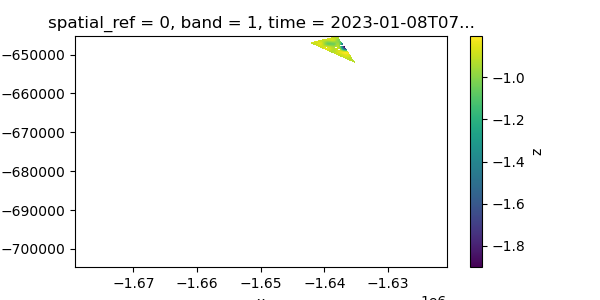

In [12]:
plt.figure(figsize=(6, 3))
# mask_mod = mod_scene.sea_surface_temperature[0,:,:].where(mod_scene.quality_level[0,:,:]>=4)
# (mod_scene.sea_surface_temperature[0,:,:]).plot.imshow(x='nj',y='ni')#,vmin=0,vmax=0.0008)
MODsst_xr_sub.plot.imshow(x='x',y='y',vmin=-3,vmax=1)

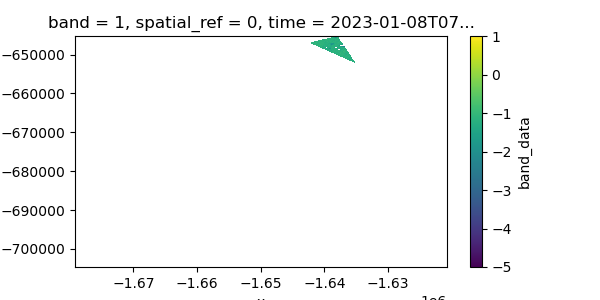

In [13]:
plt.figure(figsize=(6, 3))
# mask_mod = mod_scene.sea_surface_temperature[0,:,:].where(mod_scene.quality_level[0,:,:]>=4)
ls_scene = ls_scene.where(MODsst_xr_sub.notnull(),np.nan)
ls_scene.plot.imshow(x='x',y='y',vmin=-3,vmax=1)

In [13]:
box_x = [lonboundsC[0],lonboundsC[0],lonboundsC[1],lonboundsC[1],lonboundsC[0]]
box_y = [latboundsC[0],latboundsC[1],latboundsC[1],latboundsC[0],latboundsC[0]]

box_px = [bbox[0][0],bbox[3][0],bbox[2][0],bbox[1][0],bbox[0][0]]
box_py = [bbox[0][1],bbox[3][1],bbox[2][1],bbox[1][1],bbox[0][1]]

xp, yp = polygon.exterior.xy

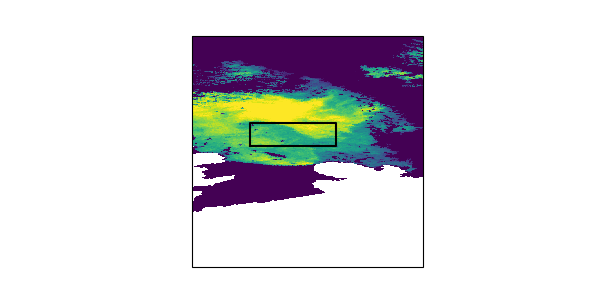

In [35]:
data0 = mod_scene.sea_surface_temperature[0,:,:]-273.15
data0 = data0.where((data0.lat<=-72) & (data0.lon<=-109))
data0 = data0.dropna(dim='nj', how='all')
data0 = data0.dropna(dim='ni', how='all')

plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolormesh(data0.lon,data0.lat,data0.values,vmin=-2,vmax=0,transform=ccrs.PlateCarree())
ax.plot(box_x,box_y,color='k',transform=ccrs.PlateCarree())
# ax.coastlines()
ax.set_ylim([-76, -72])
ax.set_xlim([-114,-110])
plt.show()

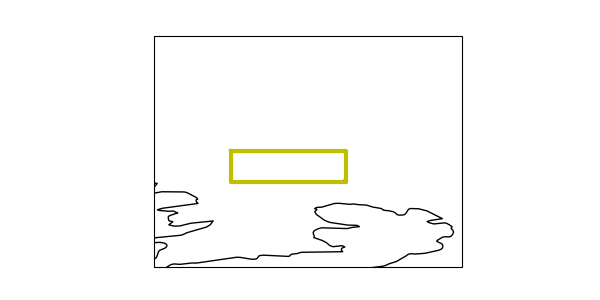

In [29]:
data0 = ls_scene
# da = xr.ones_like(data0)

plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
cb = ax.pcolormesh(data0.x,data0.y,data0.values,transform=cartopy.crs.epsg(3031)) 

# LatboundsC
ax.plot(box_x,box_y,color='k',transform=ccrs.PlateCarree())
# From bbox
ax.plot(box_px,box_py,color='r',transform=cartopy.crs.epsg(3031))
# From polygon.exterior.xy
ax.plot(xp, yp, color='y', linewidth=3, transform=cartopy.crs.epsg(3031))
ax.coastlines()

ax.set_ylim([-75, -72])
ax.set_xlim([-114,-110])
plt.show()

In [33]:
ls_scene = xr.open_dataset(lsatfiles[0],engine='rasterio')
ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
ls_scene = ls_scene['band_data'].sel(band=1)

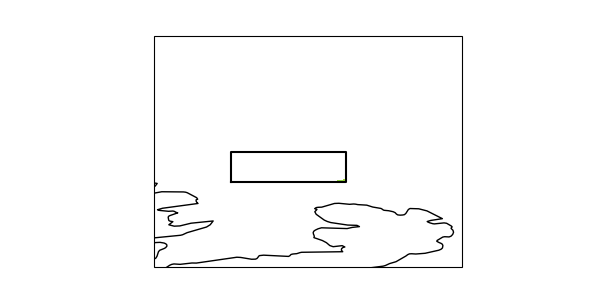

In [21]:
# Plot Landsat SST 
data0 = ls_scene
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
cb = ax.pcolormesh(data0.x,data0.y,data0.values,vmin=-8,vmax=0,transform=cartopy.crs.epsg(3031)) 
ax.plot(box_x,box_y,color='k',transform=ccrs.PlateCarree())
ax.coastlines()

ax.set_ylim([-75, -72])
ax.set_xlim([-114,-110])
plt.show()
# cbar = plt.colorbar(cb)
# plt.tight_layout()

In [ ]:
# Plot MODIS SST
data0 = mod_scene.sea_surface_temperature[0,:,:]
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
# cb = ax.pcolormesh(data0.lon,data0.lat,data0.values,vmin=240,vmax=274,transform=ccrs.PlateCarree()) 
cb = ax.pcolormesh(data0.lon,data0.lat,data0.values,vmin=268,vmax=274,transform=ccrs.PlateCarree()) 
ax.coastlines()

# # Convert the Shapely polygon to a format suitable for Cartopy
# feature1 = ShapelyFeature([final_polygon], ccrs.PlateCarree(), facecolor='green', edgecolor='black', alpha=0.4)
# # Add the polygon to the axes
# ax.add_feature(feature1)

# feature2 = ShapelyFeature([lsatpoly], ccrs.PlateCarree(), facecolor='white', edgecolor='white', alpha=0.4,zorder=2)
# # Add the polygon to the axes
# ax.add_feature(feature2)

# ax.set_ylim([-90, -55])
# ax.set_xlim([-180,-62.5])
ax.set_ylim([-75, -72])
ax.set_xlim([-107,-100])
cbar = plt.colorbar(cb)
# plt.tight_layout()

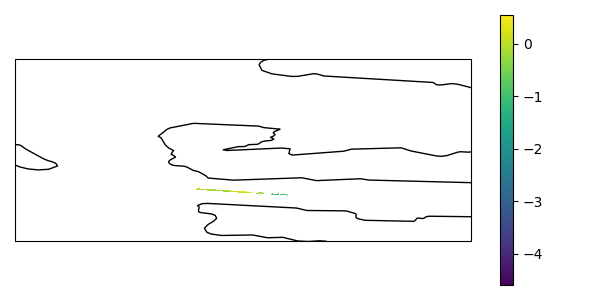

In [68]:
# For [2:3], plot water vapor data ***need to comment out the delete code above for this to work
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(xs1,ys1,ls_scene,transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_ylim([-74, -72.0])
ax.set_xlim([-105,-100])
# ax.set_ylim([-78, -72])
# ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()

In [35]:
# # Plot MODIS SST example - Cosgrove
# mod_reproj = MODsst_xr.rio.reproject("EPSG:4326")

# moddt = mod_reproj.sel(y=slice(-73.3,-73.6),x=slice(-105,-100))

# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# cb = ax.pcolormesh(moddt.x,moddt.y,moddt,vmin=-2.0,vmax=0.6,transform=ccrs.PlateCarree())
# plt.plot([-103.0,-102.0,-102.0,-103.0,-103.0],[-73.5,-73.5,-73.42,-73.42,-73.5],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
# ax.set_ylim([-73.8 , -73.1])
# ax.set_xlim([-103.9,-101.5])
# cbar = plt.colorbar(cb)
# plt.tight_layout()

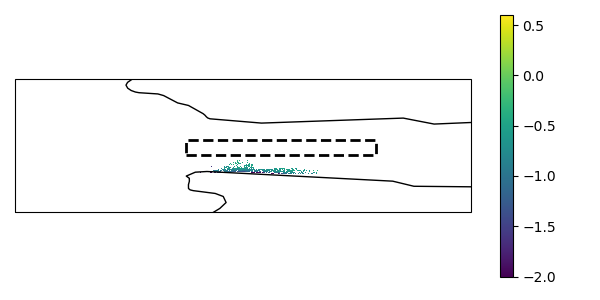

In [93]:
# # Plot Landsat SST example
# ls_reproj = ls_scene.rio.reproject("EPSG:4326")
# lsdt = ls_reproj.sel(band=1,y=slice(-73.3,-73.6),x=slice(-105,-100)).band_data

# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# cb = ax.pcolormesh(lsdt.x,lsdt.y,lsdt,vmin=-2.0,vmax=0.6,transform=ccrs.PlateCarree())
# plt.plot([-103.0,-102.0,-102.0,-103.0,-103.0],[-73.5,-73.5,-73.42,-73.42,-73.5],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
# ax.set_ylim([-73.8 , -73.1])
# ax.set_xlim([-103.9,-101.5])
# cbar = plt.colorbar(cb)
# # cbar.set_clim(-1, -6) # set limits of color map
# plt.tight_layout()

## Calculate calibration bias and trend
Uses a [RANSAC regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html), but provides comparisons to an Ordinary Least Squares regression calculation from statsmodel of the same parameters.

In [12]:
# Read in paired MODIS/Landsat data created above

# For Cosgrove region
out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_Cosgrove_20240303' 
df1 = pd.read_pickle(out_df)
lsat_mod_df_C = df1
print(f'Original # matchups at Cosgrove: {lsat_mod_df_C[lsat_mod_df_C.MODIS_SST.notna()].shape[0]}')

lsat_mod_df_C = lsat_mod_df_C[lsat_mod_df_C['MODIS_SST']>=-1.9]
lsat_mod_df_C = lsat_mod_df_C[lsat_mod_df_C['L8_SST']>=-2.5]
lsat_mod_df_C = lsat_mod_df_C[lsat_mod_df_C['MODIS_pix']>=1000]

# For Dotson polynya region
out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_Dotson_20240303_1' 
df5 = pd.read_pickle(out_df)
out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_Dotson_20240303_2' 
df6 = pd.read_pickle(out_df)
lsat_mod_df_D = pd.concat([df5,df6])
print(f'Original # matchups at Dotson: {lsat_mod_df_D[lsat_mod_df_D.MODIS_SST.notna()].shape[0]}')

# lsat_mod_df_n = lsat_mod_df_D
lsat_mod_df_D = lsat_mod_df_D[lsat_mod_df_D['MODIS_SST']>=-1.9]
lsat_mod_df_D = lsat_mod_df_D[lsat_mod_df_D['L8_SST']>=-2.5]
lsat_mod_df_D = lsat_mod_df_D[lsat_mod_df_D['MODIS_pix']>=1000]

# Concatenate data from both regions
lsat_mod_df_n = pd.concat([lsat_mod_df_C,lsat_mod_df_D])
print(f'# good matchups at Cosgrove: {lsat_mod_df_C[lsat_mod_df_C.MODIS_SST.notna()].shape[0]}, at Dotson: {lsat_mod_df_D[lsat_mod_df_D.MODIS_SST.notna()].shape[0]}')

Original # matchups at Cosgrove: 29
Original # matchups at Dotson: 47
# good matchups at Cosgrove: 25, at Dotson: 46


In [44]:
sum = lsat_mod_df_n[lsat_mod_df_n.DateTime.dt.month.isin([9,10,11,12,1,3])]
shld = lsat_mod_df_n[lsat_mod_df_n.DateTime.dt.month.isin([2])]

In [43]:
***check all the february images to see if we need to add a threshold of 2.0C or cut images or if the issue is clouds???
shld

,DateTime,MODIS_filename,MODIS_SST,MODIS_pix,L8_filename,L8_SST,L8_pix,time_dif
5,2023-02-01 14:58:00,20230201141001-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,0.667990,306996,LC08_L1GT_002112_20230201_20230209_02_T2_14580...,-1.307465,306996,0 days 00:47:59
20,2023-02-06 15:16:31,20230206142501-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,0.445931,194614,LC08_L1GT_005112_20230206_20230217_02_T2_15163...,-2.003302,194614,0 days 00:38:30
23,2023-02-13 15:22:37,20230213155001-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-0.752899,22200,LC08_L1GT_006112_20230213_20230218_02_T2_15223...,-2.038120,22200,0 days 00:27:24
4,2023-02-04 15:29:17,20230204130001-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-0.962754,6836,LC08_L1GT_007113_20230204_20230209_02_T2_15291...,-2.396818,6836,0 days 00:45:43
5,2023-03-08 15:28:29,20230308134001-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-1.861640,6454,LC08_L1GT_007112_20230308_20230320_02_T2_15282...,-1.811989,6454,0 days 00:13:28
10,2022-02-04 15:59:33,20220204120501-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-0.342707,118716,LC08_L1GT_012112_20220204_20220212_02_T2_15593...,-2.426856,118716,0 days 00:39:33
24,2023-03-08 15:28:53,20230308134001-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-1.861644,8584,LC08_L1GT_007113_20230308_20230320_02_T2_15285...,-1.857113,8584,0 days 00:13:52
25,2023-02-02 15:41:39,20230202163001-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-0.520946,52966,LC08_L1GT_009113_20230202_20230209_02_T2_15413...,-2.317933,52966,0 days 00:48:22
29,2022-02-01 15:28:39,20220201113501-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-0.721148,39693,LC08_L1GT_007112_20220201_20220211_02_T2_15283...,-2.404395,39693,0 days 00:38:38
8,2022-02-06 15:47:11,20220206115001-JPL-L2P_GHRSST-SSTskin-MODIS_T-...,-0.611948,5543,LC08_L1GT_010112_20220206_20220212_02_T2_15471...,-2.449711,5543,0 days 00:42:10


In [45]:
# Orthoganal Regression 
data0 = sum

# Original data
x_original = np.array(data0['L8_SST'])
y_original = np.array(data0['MODIS_SST'])

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model
linear = Model(linear_model)

# Create a RealData object using your DataFrame
data = RealData(x_original, y_original)

# Set up ODR with the model and data
odr = ODR(data, linear, beta0=[1., 0.])

# Run the regression
out = odr.run()

# Use the output
beta = out.beta
beta_err = out.sd_beta

# Print the summary
out.pprint()

# Predicting values using the ODR model
y_pred = linear_model(beta, x_original)

# Get R2
# Calculate Total Sum of Squares (SST)
y_mean = np.mean(y_original)
SST = np.sum((y_original - y_mean)**2)

# Calculate Residual Sum of Squares (SSR)
SSR = np.sum((y_original - y_pred)**2)

# Calculate R^2
R2 = 1 - (SSR / SST)
print("R^2:", np.around(R2,2))

Beta: [ 0.92716455 -0.10910272]
Beta Std Error: [0.0629197 0.0712945]
Beta Covariance: [[0.06721314 0.06124712]
 [0.06124712 0.08629647]]
Residual Variance: 0.058900512067248674
Inverse Condition #: 0.051254301362186484
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.75


In [70]:
# # Calculate p-value for ODR **does not have a lot of meaning

# # P-value
# # Initialize variables for bootstrapping
# n_boots = 1000  # number of bootstrap samples
# boot_coeffs = []  # to store coefficients from each bootstrap
# r2_values = [] # to store R2 from each bootstrap

# # Bootstrapping
# for _ in range(n_boots):
#     # Create a bootstrap sample with replacement
#     indices = np.random.choice(range(len(x_original)), size=len(x_original), replace=True)
#     x_boot = x_original[indices]
#     y_boot = y_original[indices]

#     # Fit ODR on the bootstrap sample
#     data_boot = RealData(x_boot, y_boot)
#     odr_boot = ODR(data_boot, Model(linear_model), beta0=[1., 0.])
#     out_boot = odr_boot.run()
#     boot_coeffs.append(out_boot.beta)  # Store the coefficients
    
#     # Predicting values using the ODR model
#     y_pred_boot = linear_model(beta, x_original)
    
#     # Calculate Total Sum of Squares (SST)
#     y_mean = np.mean(y_boot)
#     SST = np.sum((y_boot - y_mean)**2)

#     # Calculate Residual Sum of Squares (SSR)
#     SSR = np.sum((y_original - y_pred_boot)**2)

#     # Calculate R^2
#     r2_boot = 1 - (SSR / SST)
#     r2_values.append(r2_boot)

# # Convert to DataFrame for analysis
# boot_coeffs_df = pd.DataFrame(boot_coeffs, columns=['Slope', 'Intercept'])

# # Calculate p-values for coefficients
# # Here, we're comparing to the original model's coefficients (beta)
# p_values = []
# for col in boot_coeffs_df.columns:
#     p = np.sum(boot_coeffs_df[col] >= beta[list(boot_coeffs_df.columns).index(col)]) / n_boots
#     p_values.append(p)
    
# # Here, we're comparing to the original model's R2
# p_valuesR = np.sum(r2_values >= R2) / n_boots

# print("P-values:", p_values)
# print("P-values for r2:", p_valuesR)

0.93+/-0.12, -0.11+/-0.14


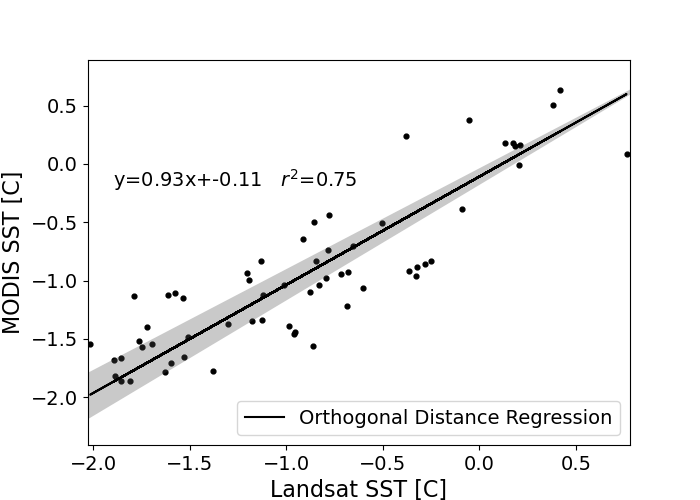

In [46]:
# Plot regression
beta_mdn = [beta[0]-beta_err[0],beta[1]-beta_err[1]]
beta_mup = [beta[0]+beta_err[0],beta[1]-beta_err[1]]
beta_bdn = [beta[0]-beta_err[0],beta[1]+beta_err[1]]
beta_bup = [beta[0]+beta_err[0],beta[1]+beta_err[1]]
print(f'{np.around(beta[0],2)}+/-{np.around(beta_err[0]*1.96,2)}, {np.around(beta[1],2)}+/-{np.around(beta_err[1]*1.96,2)}')
xfill = np.array([-2.1,0.9])

fig, ax = plt.subplots(figsize=(7, 5))
ax.tick_params(labelsize=14)
plt.scatter(x_original, y_original, s=12,color='k')
plt.plot(x_original, y_pred, color='k', label='Orthogonal Distance Regression')
# plt.fill_between(xfill, linear_model(beta_mdn, xfill), linear_model(beta_bup, xfill),alpha=0.3, facecolor='0.3')
plt.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.3, facecolor='0.3')
plt.text(-1.9,-0.2,f'y={np.around(beta[0],2)}x+{np.around(beta[1],2)}   $r^2$={np.around(R2,2)}',fontsize=14)
plt.xlim([-2.03,0.78])
# plt.ylim([-2.05,0.9])
plt.xlabel('Landsat SST [C]',fontsize=16)
plt.ylabel('MODIS SST [C]',fontsize=16)
plt.legend(loc='lower right',fontsize=14)
plt.show()

In [47]:
# Ordinary least squares regression between Landsat and MODIS SST matchups
resultC = sm.ols(formula="MODIS_SST ~ L8_SST", data=data0).fit()
print (resultC.summary())

                            OLS Regression Results                            
Dep. Variable:              MODIS_SST   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     188.8
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           4.85e-20
Time:                        05:03:09   Log-Likelihood:                -16.366
No. Observations:                  61   AIC:                             36.73
Df Residuals:                      59   BIC:                             40.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2094      0.068     -3.076      0.0

In [48]:
# RANSAC Regression for atm corrected SST
ydata = 'MODIS_SST'
xdata = 'L8_SST'
forrsac = data0[[xdata,ydata]].dropna()
xC = np.reshape(forrsac[xdata].values,(forrsac[xdata].shape[0],1))
yC = np.reshape(forrsac[ydata].values,(forrsac[ydata].shape[0],1))
reg = RANSACRegressor(random_state=0).fit(xC,yC)
yLC = reg.predict(xC)
scoreC = reg.score(xC,yC)

lreg = LinearRegression().fit(xC,yLC)
print ('m = '+str(lreg.coef_[0][0]))
print ('b = '+str(lreg.intercept_[0]))
print ('score = '+str(scoreC))

m = 0.872639979806959
b = -0.25663613743976177
score = 0.7356173661960153


In [40]:
# Permuation test for p-value pearson or RANSAC
# https://towardsdatascience.com/how-to-assess-statistical-significance-in-your-data-with-permutation-tests-8bb925b2113d

# Initialize variables
pR = []
x = xC
y = yC

# Choose number of permutations
p=10000

# Initialize permutation loop
for i in range(0,p):
    # Shuffle one of the features
    pS = copy.copy(y)
    random.shuffle(pS)
    # Computed permuted correlations and store them in pR
    reg = RANSACRegressor(random_state=0).fit(x,pS)
    pR.append(reg.score(x,pS))
#     pR.append(stats.pearsonr(xC,yLC)[0])

# Significance
p_val = len(np.where(np.abs(pR)>=np.abs(scoreC))[0])/np.float(p)
print (f'RANSAC p: {p_val}')

RANSAC p: 0.0383


In [41]:
print (lreg.coef_[0])
print (lreg.intercept_[0])

[0.94872064]
-0.04331819711443452


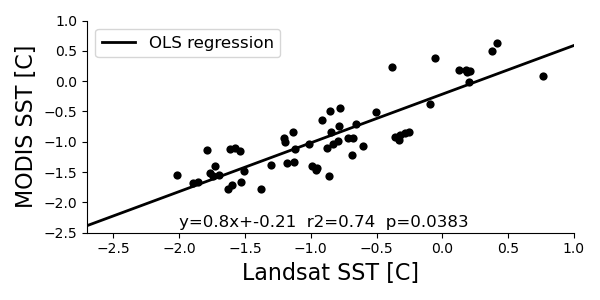

In [42]:
# Plot data points and RANSAC regression
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 3))
xi = np.arange(-7.0,5.0,1.0)

a1 = ax
a1.tick_params(labelsize=10)
a1.scatter(data0[xdata],data0[ydata],color='k',linewidth=0,s=35,label='_no label_')
# a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='r',linewidth=2,label='RANSAC regression')
# a1.scatter(xC,yLC,color='r',linewidth=0,s=35,label='_no label_')
a1.plot(xi,xi*resultC.params.L8_SST+resultC.params.Intercept,color='k',linewidth=2,label='OLS regression')
a1.text(-2.0,-2.4,f'y={np.around(resultC.params.L8_SST,2)}x+{np.around(resultC.params.Intercept,2)}  r2={np.around(resultC.rsquared,2)}  p={p_val}',fontsize=12)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
a1.set_ylim([-2.5,1])
a1.set_xlim([-2.7,1])
a1.set_xlabel('Landsat SST [C]',fontsize=16)
a1.set_ylabel('MODIS SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()

## Test to see if rioxarray reproject is causing issues

I noticed when I use rioxarray to reproject MODIS and Landsat to WGS84 (espg 4326)
that the x,y dimensions changed, which shouldn't happen. We need to keep the 
same spatial resolution and therefore dimensions. 

Here, I'm comparing the outputs of the Landsat/MODIS pair data from the method above where I immediately take the aggregate (without reprojection from espg 3031) and take the aggregate after I reproject to WGS84.

In [24]:
# Read in paired MODIS/Landsat data created above
out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230621_reproj'
df1 = pd.read_pickle(out_df)
out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230622_reproj'
df2 = pd.read_pickle(out_df)

df0 = pd.concat([df1,df2])

# Reran the first two, to check value differences after removing the reprojection step
out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230622'
df3 = pd.read_pickle(out_df)

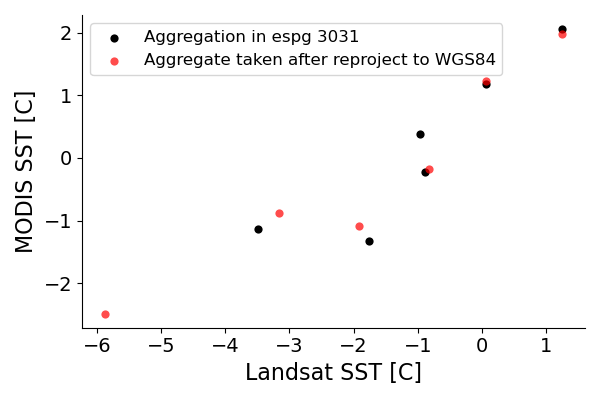

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 4))
xi = np.arange(-6.0,2.0,1.0)

data = df3  # Data all aggregated in espg 3031
data0 = df0  # Half of data is aggregated after reprojecting to espg 4236

a1 = ax
a1.tick_params(labelsize=14)
a1.scatter(data[Ldata],data[Mdata],color='k',linewidth=0,s=35,label='Aggregation in espg 3031') #'_no label_')
a1.scatter(data0[Ldata],data0[Mdata],color='r',linewidth=0,s=35,alpha=0.7,label='Aggregate taken after reproject to WGS84')
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_xlim([-5,1.5])
# a1.set_ylim([-1.8,2.0])
a1.set_ylabel('MODIS SST [C]',fontsize=16)
a1.set_xlabel('Landsat SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()

These points don't match up, so we need to worry about using rioxarray for reprojections...